# Week 4 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic and influence networks. We begin by introducing you to some straightforward approaches to network analysis. We then begin to illustrate them with word networks that we can analyze to understand the structure of how words connect with one another, and the dynamics of how their meanings flow through a discursive system. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify them). Rendering words linked as a network or discrete topology allows us to take advantage of the network analysis metrics like centrality and community.

Texts also represent moves in a social game, and we can analyze the interchange of words and phrases within them in order to understand more about the relationships between people, groups and organizations that interact with one another. For example, who influences whom? And in a singular conversation--like a discussion of tweets on comments in Facebook--or over vast stretches of time (e.g., How much was Kant influenced by Aristotle? by Plato? Was _Chinatown_ director Robert Towne influenced by Sophocles?) We will do this by extracting conversational moves from text. But note that the similarity measures from last week's homework can also be used to represent a matrix of similarities--and potential influences--from one document to another. Rendering social actors or documentary events (e.g., a book) linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, and sophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity of social relations. Moreover, we can link explicit social interactions (e.g., "friendship" on Facebook, coupling in a romantic relationship, etc.) with semantic networks to better make sense of how pepole (inter)act in the world. 

For this notebook we will use the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

# An Introduction to networks in *networkx*

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with, let's create an undirected graph:

In [2]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dictionary.

In [3]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [4]:
len(g.nodes)

3

Or if we want to get more information about the graph:

In [5]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 0
Average degree:   0.0000


We can give nodes properties, like name or type

In [6]:
g.nodes[1]

{}

In [7]:
g.nodes[1]['type'] = 'NN'

In [8]:
g.nodes[1]

{'type': 'NN'}

In [9]:
g.nodes[2]['name'] = 'dog'

In [10]:
g.nodes[2]

{'name': 'dog'}

Still pretty boring...

Lets add a couple of edges. Notice that we use the ids, but not any of the properties:

In [11]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1, 4)])
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


Note how the summary has changed. Moreover, there's one additional node, because we asked for an edge to 4.

We can also give the edges properties like weights:

In [12]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

{'weight': 2}

Let's visualize our graph now:

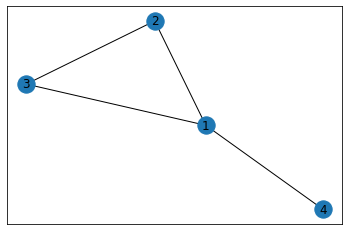

In [13]:
nx.draw_networkx(g)
plt.savefig("test.png")

Very exciting :-).

There are many things to do with the graph once we have created it, some of which we will explore here with a word semantic network.

First let's load some data: the Grimmer Senate press release corpus:

In [14]:
senReleasesDF = pandas.read_csv('../data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:3]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

We will be extracting sentences, as well as tokenizing and stemming. (You should be able to do this in your sleep now).

In [15]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

Let's begin by looking at words that co-occur in the sentences:

In [16]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

I'm going to explain the function defined above line by line. But before we look at the function, let's first look at the structure of the data that we use here, senReleasesDF['normalized_sents']. 

In [17]:
senReleasesDF['normalized_sents']

0      [[immediate, release, immediate, release, cont...
1      [[immediate, release, immediate, release, cont...
2      [[immediate, release, immediate, release], [wa...
3      [[immediate, release, immediate, release], [wa...
4      [[immediate, release, immediate, release, cont...
                             ...                        
995    [[immediate, release, department, house, urban...
996    [[immediate, release], [welcome, today, s], [i...
997    [[immediate, release, immediate, release], [wa...
998    [[immediate, release, immediate, release], [wa...
999    [[immediate, release, immediate, release], [co...
Name: normalized_sents, Length: 999, dtype: object

As you can see, senReleasesDF['normalized_sents'] is a pandas series, i.e., one-dimensional labeled array that contains any type of data. Each array is comprised of a list of lists. In particular, each array is a list of sentences, each of which is also a list of words. 

In [18]:
senReleasesDF['normalized_sents'][0] #each array is a list of sentences

[['immediate', 'release', 'immediate', 'release', 'contact'],
 ['melissa', 'wagoner'],
 ['brent', 'carney'],
 ['boston'],
 ['ma',
  'senator',
  'edward',
  'be',
  'kennedy',
  'announce',
  'today',
  'worcester',
  'polytechnic',
  'institute',
  'receive',
  'grant',
  'business',
  'international',
  'education',
  'program',
  'u',
  's',
  'department',
  'education',
  'wpi',
  'use',
  'fund',
  'project',
  'south',
  'africa',
  'improve',
  'understand',
  'south',
  'africa',
  'economy',
  'enable',
  'wpi',
  'student',
  'study',
  'south',
  'africa',
  'strengthen',
  'new',
  'england',
  'company',
  'involvement',
  'south',
  'africa'],
 ['wpi',
  'receive',
  'federal',
  'fund',
  'past',
  'year',
  'business',
  'international',
  'education',
  'program',
  'project',
  'focus',
  'namibia'],
 ['senator',
  'kennedy',
  'say',
  'principle',
  'challenge',
  'face',
  'country',
  'economy',
  'today',
  'globalization'],
 ['grant',
  'enable',
  'wpi',
  'wo

In [19]:
senReleasesDF['normalized_sents'][0][4] #each sentence is a list of words

['ma',
 'senator',
 'edward',
 'be',
 'kennedy',
 'announce',
 'today',
 'worcester',
 'polytechnic',
 'institute',
 'receive',
 'grant',
 'business',
 'international',
 'education',
 'program',
 'u',
 's',
 'department',
 'education',
 'wpi',
 'use',
 'fund',
 'project',
 'south',
 'africa',
 'improve',
 'understand',
 'south',
 'africa',
 'economy',
 'enable',
 'wpi',
 'student',
 'study',
 'south',
 'africa',
 'strengthen',
 'new',
 'england',
 'company',
 'involvement',
 'south',
 'africa']

So, what do we want to do with this data? First, we want a list of words that occurred at least once in this corpus. Then, second, we want a word-word co-occurrence matrix. This is a square matrix (i.e. matrix with the name number of rows and columns), the rows and columns of which are words, and the entries of which refer to how many times these two words appeared together in sentences.

Let's start with the first task: getting a complete list of words in the corpus. 

(1) a complete list of unique words that appeared in this corpus

Since the data is a nested list (words are elements of sentences (which are lists) that are elements of lists (documents), we need to get each sentence out of each document and then get each word out of each sentence. So we do "for sent in sentences" to get each sentence out of each document, one by one, to extract word(s) that appeared in each sentence. But, in some sentences, same word appears more than once. So we use set() function, which converts a list (which, here, is each sentence) into a set. What is a set? It's the same old set that we know in mathematics: an unordered collection of items. Each element in a set is unique. Thus, using set(), we can get unique elements (that are, here, words) of each sentence. 

What is the "|=" here? This works as union operation when used with sets (just like +=). Then, we use list() to convert this set of words into a list. 

Then we assign index to each word. You'll see why we do it in the next step--to make the word-word co-occurrence matrix. So we do "wordIndices = {w: i for i, w in enumerate(wordLst)}", which will give us a dictionary whose keys are words and values are indices that we assigned to each word.

(2) word co-occurrence matrix

Now we have the complete list of words that appeared at least once in the corpus (with index assigned to each word). Using this, we want to make word-word co-occurrence matrix.

We first make an empty matrix, the size of which is n x n, where n refers to the number of unique words in the corpus. coOcMat is the empty matrix that we made by "coOcMat = np.zeros((len(wordIndices), len(wordIndices)))"

Then we'll count how many times each pair of words co-occurred in the corpus. So, we do another loop. Each sentence ("sent") has word(s). We want to select each word in a sentence, and find which words co-occurred with this word in each sentence, and then we move on to the next word in a sentence, do the same thing, until we get to the last word in this list (which is, here, a sentence); and, we iterate the whole process for every sentence. 

How did we do it? Let's look at the second loop. By doing "for i, word1 in enumerate(sent):", we select each word in each sentence ("sent"). Then we get the index of this word that we assigned above in the word list (here, be careful, we have two indices here, one refers to the index that we assigned in "wordIndices", and the other to the temporary index in each sentence that we got from "enumerate(sent)"--here, the "index" refers to the former, the one we can find in the wordIndices), by doing: "word1Index = wordIndices[word1]". Then, we count how many times the words next to this word in this list ("sent[i +1:]") co-occurred with this word, and update it to the coOcMat matrix.  

By the way, why do we do "coOcMat = coOcMat.T + coOcMat"?

If you go back and see what the loop does, and think about the characteristics of word-word co-occurrence matrix, it would make sense. Think about the structural characteristics of word-word co-occurrence matrix: it is a square matrix; it's a symmetric matrix (i.e. a square matrix that is equal to its transpose); and, it's main diagonal is zero. That said, in this matrix, let's say A, Aij and Aji are identical. This makes sense since the co-occurrence of i and j and the same as the co-occurrence of j and i. 

Let's go back to the loop we did above, especially how we counted the co-occurrence of each pair of words. We got the index of a word, let's say i, with another words, let's say j, and then we added 1 to Aij, rather than Aji. So, to make this matrix, coOcMat, a word-word co-occurrence matrix, we should add coOcMat and the transpose of this matrix (coOcMat.T).

First, build a graph based on word cooccurences in the first 100 press releases.

In [20]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

Why do we do .sum() here? This is because senReleasesDF['normalized_sents'] is, as I mentioned above, a pandas series, and the wordCooccurrence function that we defined above takesa list rather than pandas series. So, by doing senReleasesDF['normalized_sents'].sum(), we combine all the arrays into a list (of course, of lists).

Total number of vertices:

In [21]:
len(g.nodes)

4710

Total number of edges:

In [22]:
len(g.edges)

179328

A part of the adjacency matrix of cleaned word by press releases:

In [23]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1., 14.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

We can save the graph and read it later, although this is slow if there are many edges or nodes, so we will filter first, as we will demonstrate below.

In [24]:
#nx.write_graphml(g, '../data/Obama_words.graphml')

Alternatively, we can build graphs starting with a two-mode network. Let's use the document-word frequency matrix.

In [25]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [26]:
import sklearn.feature_extraction
# in case we get a module not found error

In [27]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'][:100])

In [28]:
senVects_incidence.shape

(100, 4710)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute--this is how you need to tell networkx the graph is bipartite:

In [29]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [30]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 4810
Number of edges: 21005
Average degree:   8.7339


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. 

Let's plot the bipartite network with a quick spring layout:

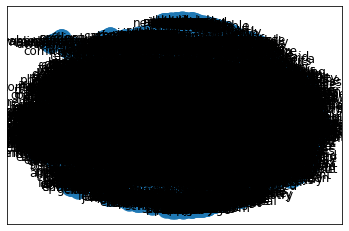

In [31]:
nx.draw_networkx(g_2mode)

With no filtering, this will not bring insight (see below). If we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [32]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i + 1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [33]:
gDoc = contractNetwork(g_2mode, 'doc')

Let's first take a look at the document-to-document network:

In [34]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


Let's construct a visualization. It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

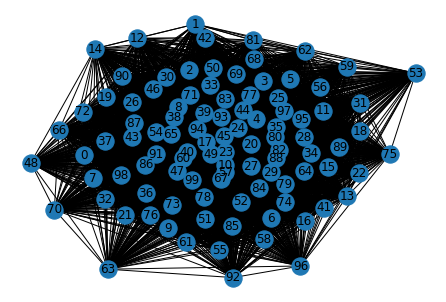

In [35]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished:

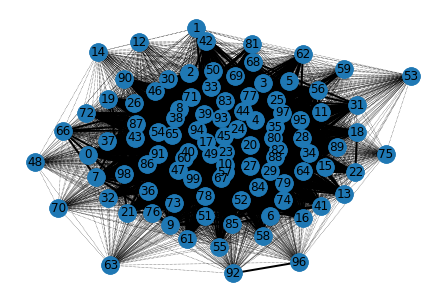

In [36]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside, while 39 and 23 are at the center. We can look at them:

In [37]:
print(len(senReleasesDF.iloc[63]['text']),"words:","\n",senReleasesDF.iloc[63]['text'].strip().replace('  ', '\n'))

314 words: 
 FOR IMMEDIATE RELEASE

Senator Kennedy issued the following statement this evening following Senator Kerrys apology

John Kerry s statement says it all
I wish the Bush administration brought as much energy and focus to trying to correct their mistakes in Iraq as it did in going after John Kerry


By the way, what's "iloc" here? iloc is used to select rows and columns in Pandas DataFrame. So,  senReleasesDF.iloc[63] gives the 63th row of senReleasesDF; and since we also specified the column (['text']), it gives us the text of the 63th row.

In [38]:
print(len(senReleasesDF.iloc[23]['text']),"words:","\n",senReleasesDF.iloc[23]['text'].strip().replace('  ', '\n'))

20603 words: 
 FOR IMMEDIATE RELEASE
REID

 We re sorry that we re starting a little bit late
but the House has some votes going
and so Leader Pelosi will be here and Congresswoman Solis real soon

 I m reminded of the story I learned as a little boy
When the kid was watching the sheep and he was supposed to yell
Wolf
when the wolf was coming
And he yelled
Wolf
as we know

Wolf
Wolf
and there was never any wolf
And finally when a wolf showed up
no one came

 And no matter how hard we try to be bipartisan here in Washington
with President Bush it s the proverbial cry for wolf

 As I said leaving the chamber last night
whatever he says
it s just the opposite

 And we re here today to talk about health care
But the cry of wolf is once again ringing in my ears because he keeps talking about how he wants to improve health care and we re now five years into this and there s been no improvement

 In fact
I hope the president mentions when he s in Tennessee today that there s almost a million 

Ah...those documents with the **most** words are unsprisingly the most central in this simple document network.

Now let's turn it around and look at the word-to-word network by documents. 

In [39]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 4710
Number of edges: 2063890
Average degree: 876.3864


First, let's reduce the number of words to a manageable size.

In [40]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.7778965933261948

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 25, then drop all the isolates. You are recommended to play with the weight here to see how the graph might look different.

In [41]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

In [42]:
len(g)

4710

In [43]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 25])

In [44]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [45]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [46]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 158
Number of edges: 458
Average degree:   5.7975


A bit smaller now, Now, let's visualize it: 

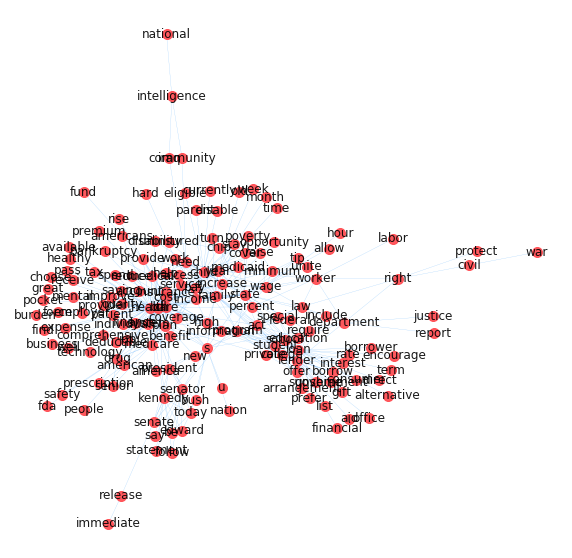

In [47]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [48]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

Let us use this oppurtunity to introduce a concept of finding communities in graphs: a popular one is the modularity measure, introduced in: Clauset, A., Newman, M. E., & Moore, C. “Finding community structure in very large networks.” Physical Review E 70(6), 2004.

networkx implements this through the above method. It yields sets of nodes, one for each community.

In [49]:
c

[frozenset({'access',
            'account',
            'act',
            'aid',
            'allow',
            'alternative',
            'america',
            'american',
            'americans',
            'arrangement',
            'available',
            'bankruptcy',
            'be',
            'benefit',
            'bill',
            'borrow',
            'borrower',
            'burden',
            'bush',
            'business',
            'care',
            'child',
            'chip',
            'choose',
            'civil',
            'college',
            'community',
            'comprehensive',
            'consumer',
            'cost',
            'cover',
            'coverage',
            'currently',
            'deductible',
            'department',
            'direct',
            'disability',
            'disable',
            'drug',
            'education',
            'edward',
            'eligible',
            'employer',
            '

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score). Note that for this case we get the same graph; this is just to demonstrate the different kinds of node dropping and graph changes we can do.

In [50]:
giant = nx.Graph(giant)

In [51]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 158
Number of edges: 458
Average degree:   5.7975


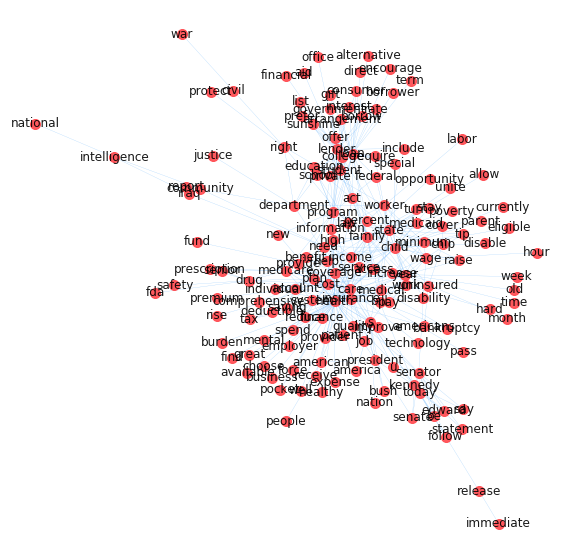

In [52]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally to investigate the structure of words at alternative slices of network density. 

Moreover, we can find cliques, or completely connected sets of nodes. 

In [53]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

health, care, child, need, state, family, year


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'america'. 

In [54]:
americanNeighbors = giant.neighbors('american')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 11
Average degree:   4.4000


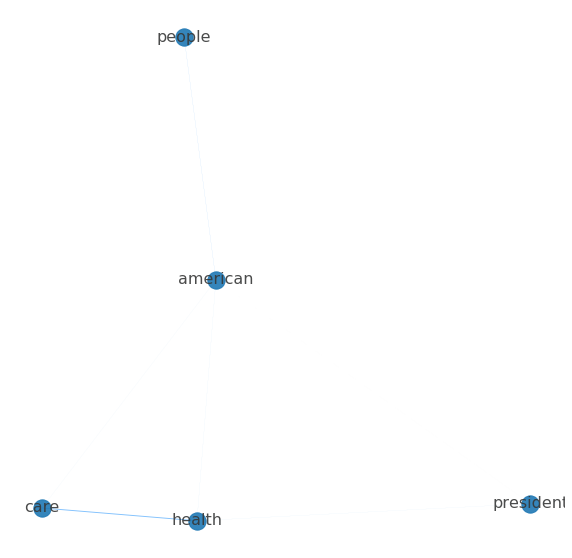

In [55]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [56]:
americanNeighbors = gWord.neighbors('american')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))
    
# for x in americanNeighborsPlus1:
#     print(x)

In [57]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: 
Type: Graph
Number of nodes: 154
Number of edges: 447
Average degree:   5.8052


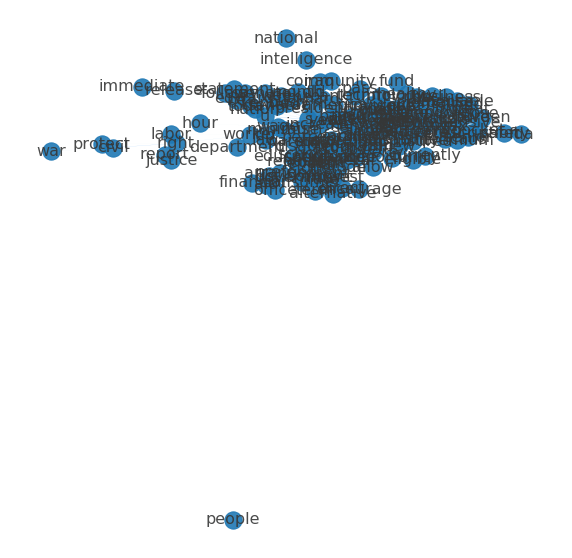

In [58]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

I use the FOMC Minutes from 2007 to 2010 to investigate the semantic structures.

In [59]:
# Write a funtion to load the documents and convert them into a dataframe
def load_corpus_to_df(corpus_name, df):
    for file in os.listdir(corpus_name + '/'):
        Minutes_whole = []
        with open(corpus_name + '/' + file, encoding='utf8', errors='ignore') as f:
            for line in f:
                line_clean = line.replace('\n', '').replace('\t', ' ')
                if line_clean:
                    Minutes_whole.append(line_clean)
        df = df.append({'date': file[5:-4], 'text': ' '.join(Minutes_whole)}, ignore_index=True)
    return df

In [60]:
# Construct the dataframe for Minutes
Minutes_pre_txt = r"..\week-1\FOMC_pre"
Minutes_post_txt = r"..\week-1\FOMC_post"

pre_df = pandas.DataFrame(columns = ["date", "text"])
pre_df = load_corpus_to_df(Minutes_pre_txt, pre_df)

post_df = pandas.DataFrame(columns = ["date", "text"])
post_df = load_corpus_to_df(Minutes_post_txt, post_df)

Minutes_df = pre_df.append(post_df, ignore_index=True)

In [61]:
# Tokenize and normalize
Minutes_df['tokenized_sents'] = Minutes_df['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
Minutes_df['normalized_sents'] = Minutes_df['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [62]:
Minutes_df.head()

date                                               text  \
0  20070131  In the agenda for this meeting, it was reporte...   
1  20070321  The Manager of the System Open Market Account ...   
2  20070509  The Manager of the System Open Market Account ...   
3  20070628  The information reviewed at the June meeting s...   
4  20070807  In the agenda for this meeting, it was reporte...   

                                     tokenized_sents  \
0  [[In, the, agenda, for, this, meeting, it, was...   
1  [[The, Manager, of, the, System, Open, Market,...   
2  [[The, Manager, of, the, System, Open, Market,...   
3  [[The, information, reviewed, at, the, June, m...   
4  [[In, the, agenda, for, this, meeting, it, was...   

                                    normalized_sents  
0  [[agendum, meet, report, advice, election, fol...  
1  [[manager, system, open, market, account, repo...  
2  [[manager, system, open, market, account, repo...  
3  [[information, review, june, meet, suggest, ex...  
4  [[agendum, meet, report, advice, election, eri...

In [63]:
# Vectorize
Minutes_Vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
Minutes_Vects_incidence = Minutes_Vectorizer.fit_transform(Minutes_df['text'])

In [64]:
# Create network by word occurance
g_2mode_Minutes = nx.Graph()

# Define all the nodes
g_2mode_Minutes.add_nodes_from((Minutes_Vectorizer.get_feature_names()[i] for i in range(Minutes_Vects_incidence.shape[1])), bipartite = 'word')
g_2mode_Minutes.add_nodes_from(range(Minutes_Vects_incidence.shape[0]), bipartite = 'date')

# Add all the edges
g_2mode_Minutes.add_edges_from(((d, Minutes_Vectorizer.get_feature_names()[w], {'weight': Minutes_Vects_incidence[d, w]}) for d, w in zip(*Minutes_Vects_incidence.nonzero())))

print(nx.info(g_2mode_Minutes))

Name: 
Type: Graph
Number of nodes: 3098
Number of edges: 29123
Average degree:  18.8012


In [65]:
# Modify the function so that I can use this function in my application
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [66]:
# Transform into one-mode network
gDoc_Minutes = contractNetwork(g_2mode_Minutes, 'date')
print(nx.info(gDoc_Minutes))

Name: 
Type: Graph
Number of nodes: 32
Number of edges: 496
Average degree:  31.0000


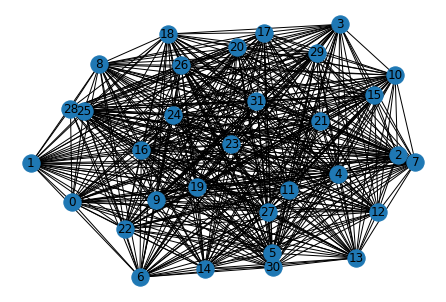

In [67]:
# Visualize the network
layout_Minutes = nx.spring_layout(gDoc_Minutes, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc_Minutes, pos = layout_Minutes, labels = {n:n for n in gDoc_Minutes.nodes()}) 

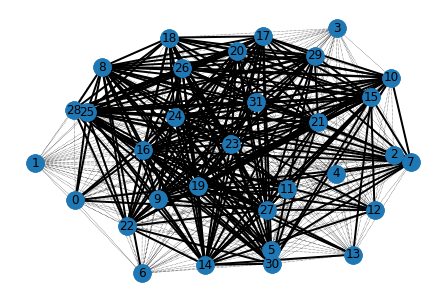

In [68]:
# Take weight into account
wMedian_Minutes = np.median([d['weight'] for n1, n2, d in gDoc_Minutes.edges(data = True)]) 
edgesHigh_Minutes = [(n1, n2) for n1, n2, d in gDoc_Minutes.edges(data = True) if d['weight'] > wMedian_Minutes]
edgesLow_Minutes = [(n1, n2) for n1, n2, d in gDoc_Minutes.edges(data = True) if d['weight'] <= wMedian_Minutes]
nx.draw(gDoc_Minutes, pos = layout_Minutes, labels = {n:n for n in gDoc_Minutes.nodes()}, edgelist = edgesLow_Minutes, style='dotted', width=.5)
nx.draw(gDoc_Minutes, pos = layout_Minutes, nodelist=None, edgelist = edgesHigh_Minutes, width=2)

From the above figure, we can see that 9 and 24 are heavily connected, while 0, 1, 2 are not. Next, let's take 2 and 24 as two examples.

In [69]:
print("There are {} words in the the Minutes 2, ".format(len(Minutes_df.iloc[2]['text'])) + 
      "while there are {} words in the Minutes 24.".format(len(Minutes_df.iloc[24]['text'])))

There are 25362 words in the the Minutes 2, while there are 70059 words in the Minutes 24.


It seems that Minutes with more words are at the center. The result might also indicate that the Minutes on May 9, 2007 covers less economic issues of concern than that on Jan. 27, 2010.

In [70]:
# Turn to word-to-word network, with 9 and 24 as two examples
g9 = wordCooccurrence(Minutes_df.loc[9, ['normalized_sents']].sum())
len(g9)

862

In [71]:
# Generate the giant (the weight is adjusted to make two giants look similar)
g9.remove_edges_from([(n1, n2) for n1, n2, d in g9.edges(data = True) if d['weight'] <= 9])
g9.remove_nodes_from(list(nx.isolates(g9)))
giant9 = max(connected_component_subgraphs(g9), key=len) # keep just the giant connected component
print(nx.info(giant9))

Name: 
Type: Graph
Number of nodes: 53
Number of edges: 107
Average degree:   4.0377


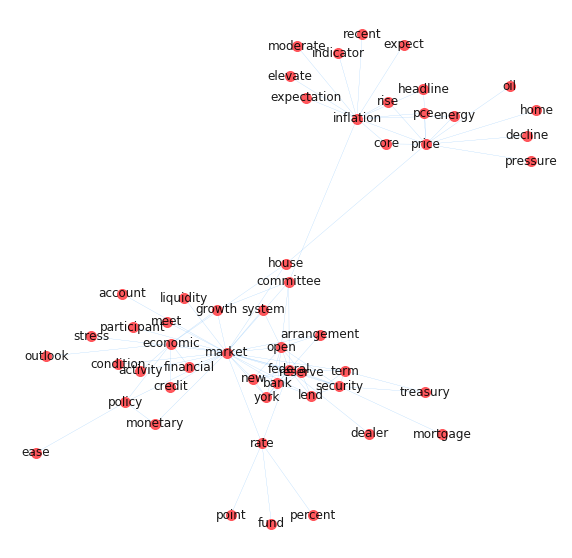

In [72]:
# Visualization
layout9 = nx.spring_layout(giant9, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant9, ax = ax, pos = layout9, labels = {n:n for n in giant9.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

In [73]:
# Examine the communities
c9 = list(greedy_modularity_communities(giant9))
c9

[frozenset({'account',
            'activity',
            'arrangement',
            'bank',
            'committee',
            'condition',
            'credit',
            'dealer',
            'ease',
            'economic',
            'federal',
            'financial',
            'fund',
            'growth',
            'house',
            'lend',
            'liquidity',
            'market',
            'meet',
            'monetary',
            'mortgage',
            'new',
            'open',
            'outlook',
            'participant',
            'percent',
            'point',
            'policy',
            'rate',
            'reserve',
            'security',
            'stress',
            'system',
            'term',
            'treasury',
            'york'}),
 frozenset({'core',
            'decline',
            'elevate',
            'energy',
            'expect',
            'expectation',
            'headline',
            'home',
         

In [74]:
# Find the cliques
print(', '.join(max(nx.clique.find_cliques(giant9), key = lambda x: len(x))))

market, federal, open, reserve, new, york, bank


In [75]:
# Find neighbors of "security"
securityNeighbors9 = giant9.neighbors('security')
g9_security = giant9.subgraph(securityNeighbors9)
print(nx.info(g9_security))

Name: 
Type: Graph
Number of nodes: 9
Number of edges: 26
Average degree:   5.7778


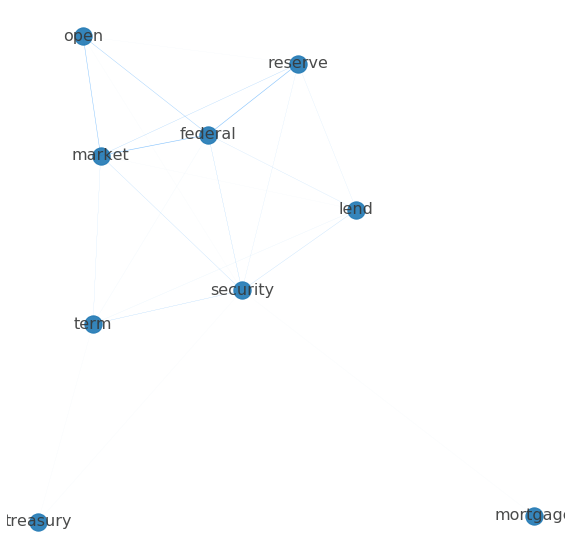

In [76]:
layout_security9 = nx.spring_layout(g9_security, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight_security9 = max((d['weight'] for n1, n2, d in g9_security.edges(data = True)))
minWeight_security9 = min((d['weight'] for n1, n2, d in g9_security.edges(data = True)))
nx.draw(g9_security, ax = ax, pos = layout_security9, labels = {n:n for n in g9_security.nodes()},
        width=[(d['weight'] - minWeight_security9 + .7) / maxWeight_security9 for n1, n2, d in g9_security.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [77]:
# Do the same thing for 24
g24 = wordCooccurrence(Minutes_df.loc[24, ['normalized_sents']].sum())
len(g24)

1270

In [78]:
# Generate the giant (the weight is adjusted to make two giants look similar)
g24.remove_edges_from([(n1, n2) for n1, n2, d in g24.edges(data = True) if d['weight'] <= 22])
g24.remove_nodes_from(list(nx.isolates(g24)))
giant24 = max(connected_component_subgraphs(g24), key=len) # keep just the giant connected component
print(nx.info(giant24))

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 136
Average degree:   5.4400


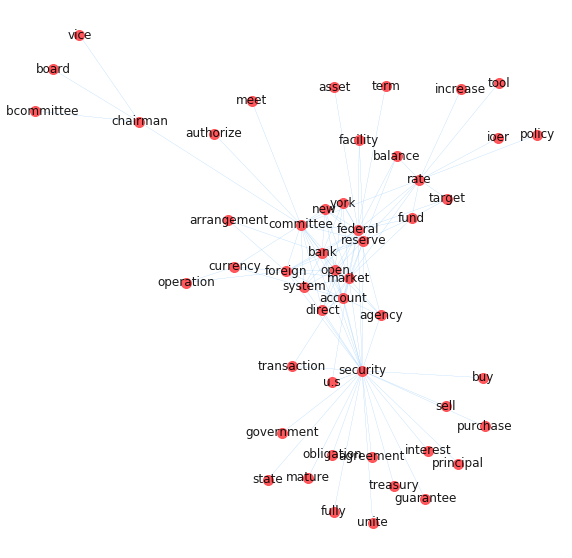

In [79]:
# Visualization
layout24 = nx.spring_layout(giant24, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant24, ax = ax, pos = layout24, labels = {n:n for n in giant24.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

In [80]:
# Examine the communities
c24 = list(greedy_modularity_communities(giant24))
c24

[frozenset({'account',
            'agency',
            'agreement',
            'arrangement',
            'asset',
            'authorize',
            'balance',
            'bank',
            'board',
            'buy',
            'chairman',
            'committee',
            'currency',
            'direct',
            'facility',
            'federal',
            'foreign',
            'fully',
            'fund',
            'government',
            'guarantee',
            'increase',
            'interest',
            'ioer',
            'market',
            'mature',
            'meet',
            'new',
            'obligation',
            'open',
            'operation',
            'policy',
            'principal',
            'purchase',
            'rate',
            'reserve',
            'security',
            'sell',
            'state',
            'subcommittee',
            'system',
            'target',
            'term',
            'tool',
    

In [81]:
# Find the cliques
print(', '.join(max(nx.clique.find_cliques(giant24), key = lambda x: len(x))))

security, market, open, account, federal, committee, foreign, bank, system


In [82]:
# Find neighbors of "security"
securityNeighbors24 = giant24.neighbors('security')
g24_security = giant24.subgraph(securityNeighbors24)
print(nx.info(g24_security))

Name: 
Type: Graph
Number of nodes: 28
Number of edges: 83
Average degree:   5.9286


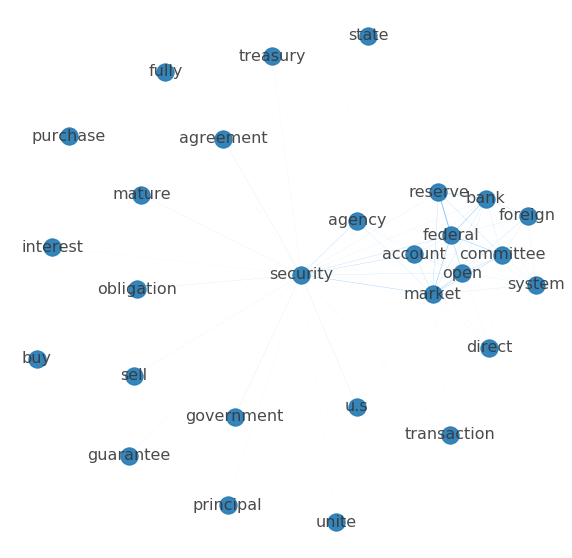

In [83]:
layout_security24 = nx.spring_layout(g24_security, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight_security24 = max((d['weight'] for n1, n2, d in g24_security.edges(data = True)))
minWeight_security24 = min((d['weight'] for n1, n2, d in g24_security.edges(data = True)))
nx.draw(g24_security, ax = ax, pos = layout_security24, labels = {n:n for n in g24_security.nodes()},
        width=[(d['weight'] - minWeight_security24 + .7) / maxWeight_security24 for n1, n2, d in g24_security.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

### Summary
Minutes 9 corresponds to the FOMC meeting on Mar. 18, 2008 (pre-crisis), while Minutes 24 corresponds to the meeting on Jan. 27, 2010 (post-crisis), so the focus of the two documents should be different. My analysis verifies this point. From word-to-word network, Minutes 9 is more focused on economic growth, housing price, energy price, and liquidity, which indicates that the economy is well-functioning; Minutes 26 places more importance on security operation, foreign reserve, and target rate, which indicates that dense monetary policies are taking place. From the communities, Minutes 9 has two separate communities, one focuses on current economic outlook, and the other focuses on housing and energy price; Minutes 24 has only one communities, describing the policy movement. From the cliques, "security" is in the cliques of Minutes 26 but not in Minutes 9, which also indicates that more monetary policies are taking place in 2010. Finally, the neighbors of securities illustrates the above conclusion more vividly.

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [84]:
dcentralities = nx.degree_centrality(giant)

In [85]:
dcentralities['american']

0.038216560509554146

In [86]:
sorted(dcentralities.items(), reverse = True, key = lambda x:x[1])

[('health', 0.43312101910828027),
 ('care', 0.21656050955414013),
 ('lender', 0.20382165605095542),
 ('loan', 0.20382165605095542),
 ('child', 0.19745222929936307),
 ('state', 0.1910828025477707),
 ('family', 0.1656050955414013),
 ('cost', 0.15923566878980894),
 ('year', 0.15286624203821658),
 ('program', 0.11464968152866242),
 ('s', 0.11464968152866242),
 ('plan', 0.10828025477707007),
 ('kennedy', 0.09554140127388536),
 ('need', 0.089171974522293),
 ('senator', 0.089171974522293),
 ('college', 0.089171974522293),
 ('student', 0.08280254777070065),
 ('wage', 0.08280254777070065),
 ('medicare', 0.08280254777070065),
 ('act', 0.07643312101910829),
 ('worker', 0.07006369426751592),
 ('drug', 0.07006369426751592),
 ('bill', 0.07006369426751592),
 ('law', 0.06369426751592357),
 ('department', 0.06369426751592357),
 ('work', 0.05732484076433121),
 ('high', 0.05732484076433121),
 ('private', 0.05732484076433121),
 ('minimum', 0.05732484076433121),
 ('education', 0.050955414012738856),
 ('ben

In [87]:
max(dcentralities.items(), key = lambda x : x[1])

('health', 0.43312101910828027)

By the way, why do we have .items() here? This is because decentralities is a dictionary.

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

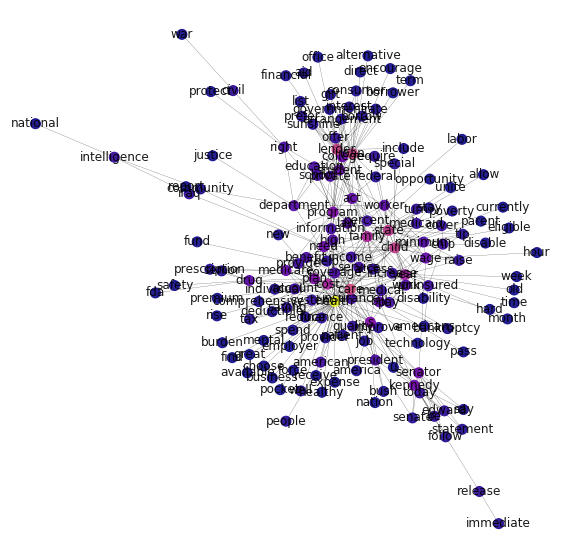

In [88]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

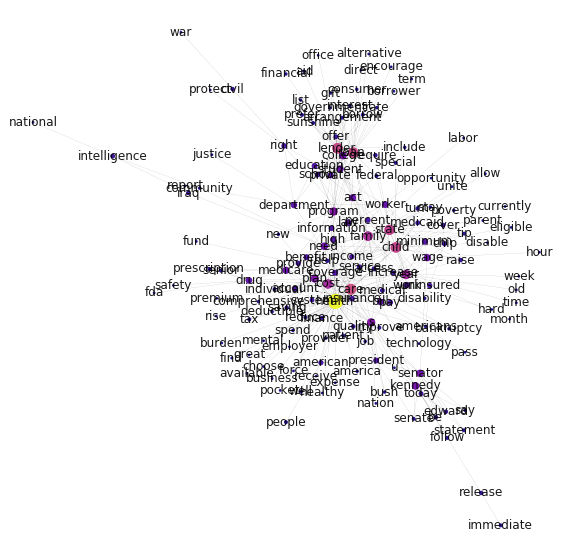

In [89]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is:

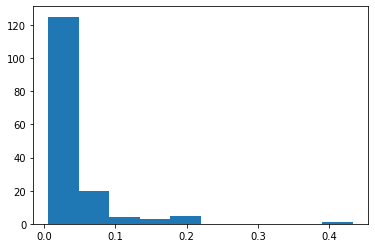

In [90]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree?

In [91]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.43312101910828027),
 ('care', 0.21656050955414013),
 ('lender', 0.20382165605095542),
 ('loan', 0.20382165605095542),
 ('child', 0.19745222929936307),
 ('state', 0.1910828025477707),
 ('family', 0.1656050955414013),
 ('cost', 0.15923566878980894),
 ('year', 0.15286624203821658),
 ('program', 0.11464968152866242)]

In [92]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('justice', 0.006369426751592357),
 ('u', 0.006369426751592357),
 ('report', 0.006369426751592357),
 ('encourage', 0.006369426751592357),
 ('parent', 0.006369426751592357),
 ('war', 0.006369426751592357),
 ('borrower', 0.006369426751592357),
 ('great', 0.006369426751592357),
 ('direct', 0.006369426751592357),
 ('pass', 0.006369426751592357)]

Consider another very different measure, which is *betweenness* centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high *betweenness centrality* nodes may not have the highest *degree centrality*.

In [93]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [94]:
centralities['american']

0.012738853503184714

In [95]:
max(centralities.items(), key = lambda x : x[1])

('health', 0.4203621024825363)

We can color and size the nodes by betweenness centrality:

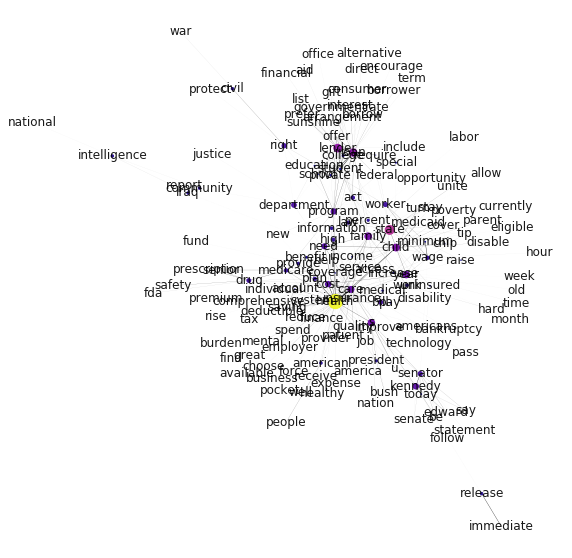

In [96]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

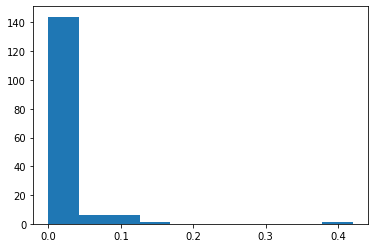

In [97]:
plt.hist(list(centralities.values()))
plt.show()

This is an exponential distrubution, but you might need to add more nodes to see it clearly.

What are the top ten words in terms of betweenness?

In [98]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.43312101910828027),
 ('care', 0.21656050955414013),
 ('lender', 0.20382165605095542),
 ('loan', 0.20382165605095542),
 ('child', 0.19745222929936307),
 ('state', 0.1910828025477707),
 ('family', 0.1656050955414013),
 ('cost', 0.15923566878980894),
 ('year', 0.15286624203821658),
 ('program', 0.11464968152866242)]

Here it appears that "health"/"care", "family"/"children" are key concepts that connect others in the broader network. This is interesting in that they seem to be domain-specific rather than linking words like "state".

What are words lower down?

In [99]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('cover', 0.03184713375796178),
 ('today', 0.03184713375796178),
 ('medicaid', 0.03184713375796178),
 ('increase', 0.03184713375796178),
 ('system', 0.03184713375796178),
 ('release', 0.025477707006369428),
 ('be', 0.025477707006369428),
 ('iraq', 0.025477707006369428),
 ('raise', 0.025477707006369428),
 ('finance', 0.025477707006369428)]

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [100]:
centralities = nx.closeness_centrality(giant)

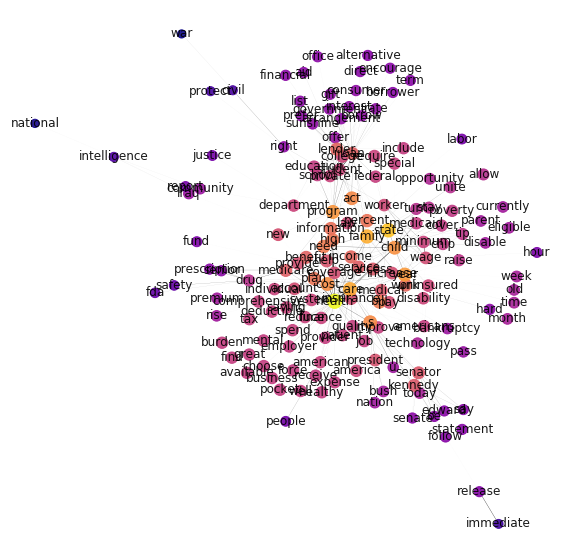

In [101]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [102]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.5508771929824562),
 ('state', 0.5048231511254019),
 ('family', 0.4845679012345679),
 ('care', 0.4801223241590214),
 ('year', 0.4658753709198813),
 ('program', 0.46176470588235297),
 ('child', 0.4563953488372093),
 ('cost', 0.4511494252873563),
 ('s', 0.44857142857142857),
 ('act', 0.4472934472934473)]

In [103]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('report', 0.26837606837606837),
 ('people', 0.26610169491525426),
 ('safety', 0.25363489499192243),
 ('fda', 0.25363489499192243),
 ('intelligence', 0.2353823088455772),
 ('civil', 0.22753623188405797),
 ('protect', 0.22687861271676302),
 ('immediate', 0.22081575246132207),
 ('national', 0.19076549210206561),
 ('war', 0.18557919621749408)]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [104]:
centralities = nx.eigenvector_centrality(giant)

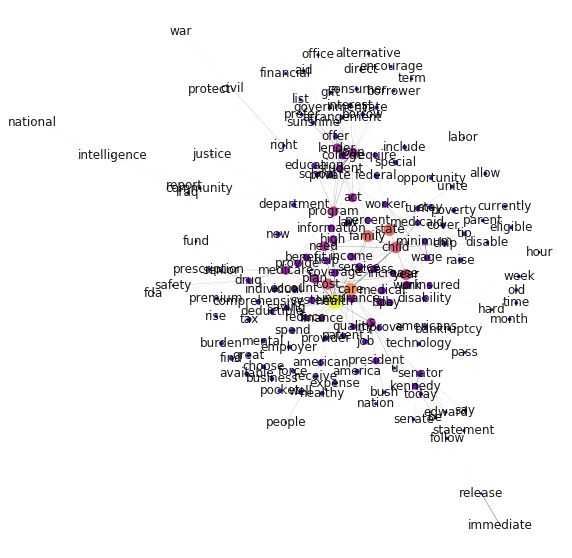

In [105]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

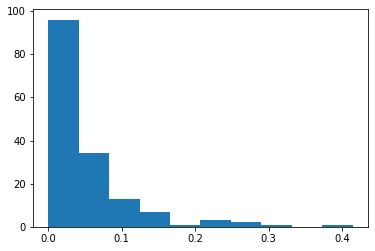

In [106]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [107]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.41421797822651285),
 ('care', 0.29776974131934486),
 ('family', 0.2502951111949896),
 ('state', 0.24969793403288468),
 ('child', 0.22995111817868857),
 ('cost', 0.21729639645054502),
 ('year', 0.2149130844833352),
 ('program', 0.17137587976970217),
 ('need', 0.1606204848201531),
 ('plan', 0.15339424720008993)]

In [108]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('safety', 0.003760677449635504),
 ('fda', 0.003760677449635504),
 ('justice', 0.002536534495916525),
 ('report', 0.002536534495916525),
 ('intelligence', 0.0017995098835093789),
 ('civil', 0.0008701062371919275),
 ('protect', 0.0008046732394885576),
 ('immediate', 0.00038960838254329045),
 ('national', 0.00012643460042104814),
 ('war', 6.113716692984287e-05)]

We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [109]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [110]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 122
Average degree:   9.7600


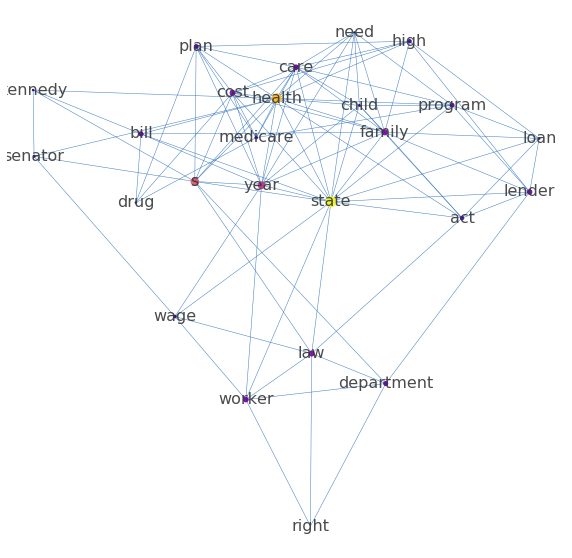

In [111]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges:

In [112]:
nx.density(giant)

0.03692655002821898

We can also calculate the average degree per node:

In [113]:
np.mean([v for w,v in nx.degree(giant)])

5.7974683544303796

The diameter calculates the average distance between any two nodes in the network:

In [114]:
nx.diameter(giant)

8

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

For this exercise I focus on the Minutes 9.

In [115]:
# Expand the gaint so that it contains more nodes
g9 = wordCooccurrence(Minutes_df.loc[9, ['normalized_sents']].sum())
g9.remove_edges_from([(n1, n2) for n1, n2, d in g9.edges(data = True) if d['weight'] <= 5])
g9.remove_nodes_from(list(nx.isolates(g9)))
giant9E = max(connected_component_subgraphs(g9), key=len) # keep just the giant connected component
print(nx.info(giant9E))

Name: 
Type: Graph
Number of nodes: 132
Number of edges: 353
Average degree:   5.3485


The top 10 words in terms of degree centrality are:
 [('market', 0.549618320610687), ('federal', 0.2748091603053435), ('price', 0.24427480916030533), ('inflation', 0.23664122137404578), ('economic', 0.16793893129770993)]
The bottom 10 words in terms of degree centrality are:
 [('oil', 0.007633587786259542), ('month', 0.007633587786259542), ('statement', 0.007633587786259542), ('function', 0.007633587786259542), ('anticipate', 0.007633587786259542)]
The distribution of the degree centrality is:


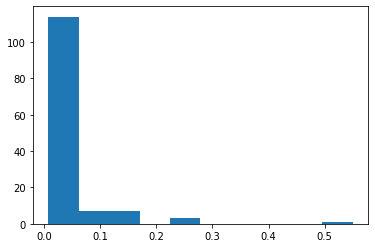

In [116]:
# Degree centrality
dcentralities9E = nx.degree_centrality(giant9E)
print("The top 10 words in terms of degree centrality are:\n", 
      sorted(dcentralities9E.items(), key = lambda x: x[1], reverse = True)[:5])
print("The bottom 10 words in terms of degree centrality are:\n", 
      sorted(dcentralities9E.items(), key = lambda x: x[1])[:5])
print("The distribution of the degree centrality is:")
plt.hist(list(dcentralities9E.values()))
plt.show()

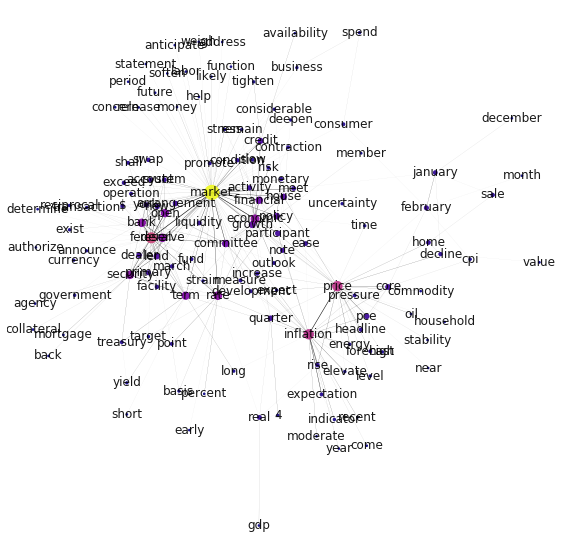

In [117]:
# Visualization
layout9E = nx.spring_layout(giant9E, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
maxC9E = max(dcentralities9E.items(), key = lambda x : x[1])[1]
maxWeight9E = max((d['weight'] for n1, n2, d in giant9E.edges(data = True)))
minWeight9E = min((d['weight'] for n1, n2, d in giant9E.edges(data = True)))
nx.draw(giant9E, ax = ax, pos = layout9E, labels = {n:n for n in giant9E.nodes()},
        width=[(d['weight'] - minWeight9E + .7) / maxWeight9E for n1, n2, d in giant9E.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities9E[n] / maxC9E for n in giant9E.nodes],
        node_size = [dcentralities9E[n] / maxC9E * 200 for n in giant9E.nodes],
        cmap = plt.get_cmap('plasma'))

The top 10 words in terms of betweenness centrality are:
 [('market', 0.5343967132508527), ('price', 0.2507754112863371), ('inflation', 0.1424008090145435), ('rate', 0.11404143054244235), ('federal', 0.11185022475379766)]
The bottom 10 words in terms of betweenness centrality are:
 [('oil', 0.0), ('target', 0.0), ('month', 0.0), ('statement', 0.0), ('function', 0.0)]
The distribution of the betweenness centrality is:


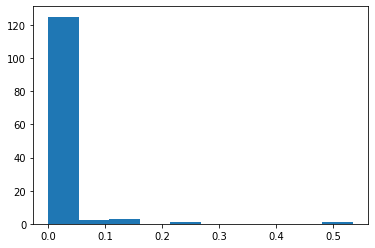

In [118]:
# Betweenness centrality
bcentralities9E = nx.betweenness.betweenness_centrality(giant9E)
print("The top 10 words in terms of betweenness centrality are:\n", 
      sorted(bcentralities9E.items(), key = lambda x: x[1], reverse = True)[:5])
print("The bottom 10 words in terms of betweenness centrality are:\n", 
      sorted(bcentralities9E.items(), key = lambda x: x[1])[:5])
print("The distribution of the betweenness centrality is:")
plt.hist(list(bcentralities9E.values()))
plt.show()

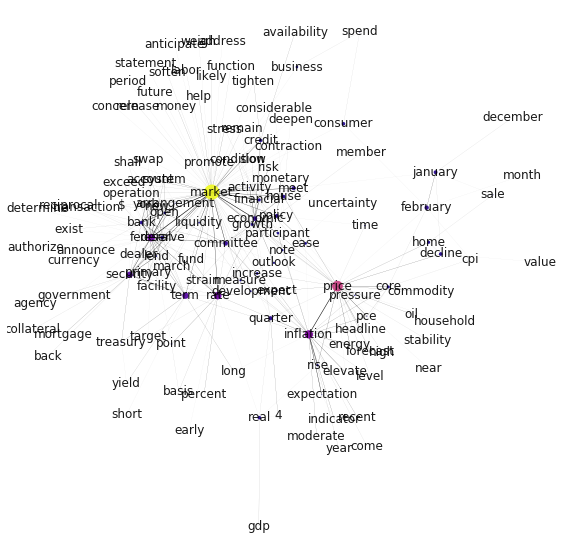

In [119]:
# Visualization
fig, ax = plt.subplots(figsize = (10,10))
maxC9E = max(bcentralities9E.items(), key = lambda x : x[1])[1]
maxWeight9E = max((d['weight'] for n1, n2, d in giant9E.edges(data = True)))
minWeight9E = min((d['weight'] for n1, n2, d in giant9E.edges(data = True)))
nx.draw(giant9E, ax = ax, pos = layout9E, labels = {n:n for n in giant9E.nodes()},
        width=[(d['weight'] - minWeight9E + .7) / maxWeight9E for n1, n2, d in giant9E.edges(data = True)], 
        alpha = .9, 
        node_color = [bcentralities9E[n] / maxC9E for n in giant9E.nodes],
        node_size = [bcentralities9E[n] / maxC9E * 200 for n in giant9E.nodes],
        cmap = plt.get_cmap('plasma'))

The top 10 words in terms of closeness centrality are:
 [('market', 0.6421568627450981), ('price', 0.5198412698412699), ('rate', 0.5177865612648221), ('committee', 0.4962121212121212), ('economic', 0.49063670411985016)]
The bottom 10 words in terms of closeness centrality are:
 [('december', 0.24440298507462688), ('gdp', 0.25992063492063494), ('value', 0.26043737574552683), ('month', 0.2635814889336016), ('sale', 0.26464646464646463)]
The distribution of the closeness centrality is:


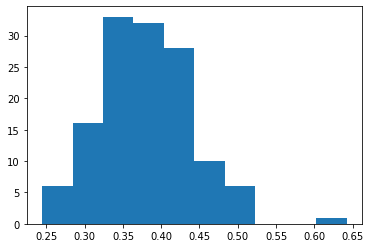

In [120]:
# Closeness centrality
ccentralities9E = nx.closeness_centrality(giant9E)
print("The top 10 words in terms of closeness centrality are:\n", 
      sorted(ccentralities9E.items(), key = lambda x: x[1], reverse = True)[:5])
print("The bottom 10 words in terms of closeness centrality are:\n", 
      sorted(ccentralities9E.items(), key = lambda x: x[1])[:5])
print("The distribution of the closeness centrality is:")
plt.hist(list(ccentralities9E.values()))
plt.show()

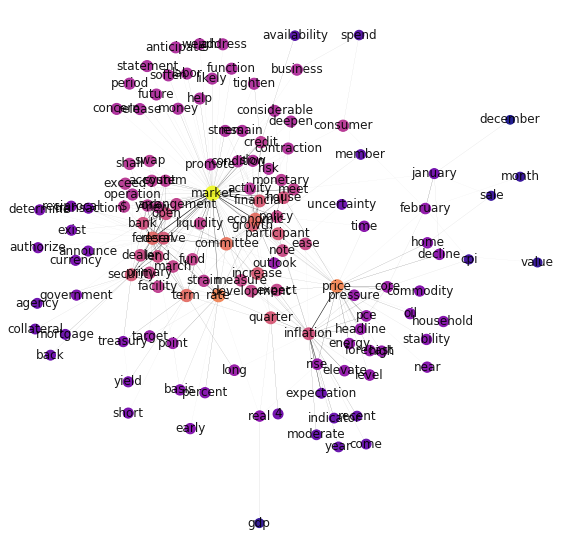

In [121]:
# Visualization
fig, ax = plt.subplots(figsize = (10,10))
maxC9E = max(ccentralities9E.items(), key = lambda x : x[1])[1]
maxWeight9E = max((d['weight'] for n1, n2, d in giant9E.edges(data = True)))
minWeight9E = min((d['weight'] for n1, n2, d in giant9E.edges(data = True)))
nx.draw(giant9E, ax = ax, pos = layout9E, labels = {n:n for n in giant9E.nodes()},
        width=[(d['weight'] - minWeight9E + .7) / maxWeight9E for n1, n2, d in giant9E.edges(data = True)], 
        alpha = .9, 
        node_color = [ccentralities9E[n] / maxC9E for n in giant9E.nodes],
        node_size = [ccentralities9E[n] / maxC9E * 200 for n in giant9E.nodes],
        cmap = plt.get_cmap('plasma'))

The top 10 words in terms of eigenvector centrality are:
 [('market', 0.4669022157865231), ('federal', 0.28794730153522624), ('reserve', 0.22337017158369477), ('bank', 0.20429723353700419), ('open', 0.20282165601921276)]
The bottom 10 words in terms of eigenvector centrality are:
 [('december', 0.0005531166386937207), ('value', 0.0009994255075459883), ('month', 0.0012777018462716355), ('gdp', 0.0016143119679470457), ('sale', 0.0017122060290870836)]
The distribution of the eigenvector centrality is:


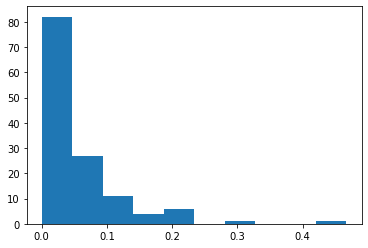

In [122]:
# Eigenvector centrality
ecentralities9E = nx.eigenvector_centrality(giant9E)
print("The top 10 words in terms of eigenvector centrality are:\n", 
      sorted(ecentralities9E.items(), key = lambda x: x[1], reverse = True)[:5])
print("The bottom 10 words in terms of eigenvector centrality are:\n", 
      sorted(ecentralities9E.items(), key = lambda x: x[1])[:5])
print("The distribution of the eigenvector centrality is:")
plt.hist(list(ecentralities9E.values()))
plt.show()

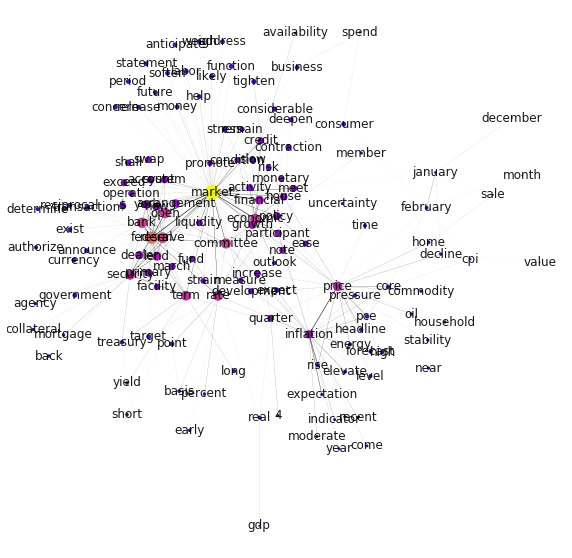

In [123]:
# Visualization
fig, ax = plt.subplots(figsize = (10,10))
maxC9E = max(ecentralities9E.items(), key = lambda x : x[1])[1]
maxWeight9E = max((d['weight'] for n1, n2, d in giant9E.edges(data = True)))
minWeight9E = min((d['weight'] for n1, n2, d in giant9E.edges(data = True)))
nx.draw(giant9E, ax = ax, pos = layout9E, labels = {n:n for n in giant9E.nodes()},
        width=[(d['weight'] - minWeight9E + .7) / maxWeight9E for n1, n2, d in giant9E.edges(data = True)], 
        alpha = .9, 
        node_color = [ecentralities9E[n] / maxC9E for n in giant9E.nodes],
        node_size = [ecentralities9E[n] / maxC9E * 200 for n in giant9E.nodes],
        cmap = plt.get_cmap('plasma'))

In [124]:
# Global statistics
print("The density is {}".format(nx.density(giant9E)))
print("The average degree per node is {}".format(np.mean([v for w,v in nx.degree(giant9E)])))
print("The diameter is {}".format(nx.diameter(giant9E)))

The density is 0.04082812861438816
The average degree per node is 5.348484848484849
The diameter is 6


### Summary
According to different centrality measures, "market", "federal", "price", "inflation", and "rate" are the most central words, while "household", "oil", "year", "december", "month", "value", "gdp", and "sale" are the least central words. It could be found that degree centrality covers more topics, while eigenvector centrality puts more weights on n-grams. The above analyses suggest that the central bankers are trying to stabilize the price level and control the inflation before the crisis.  

The density and the average degree per node are relatively high while the diameter is relatively low, indicating that the topics covered in Minutes 9 are to some extent convergent and connected to each other.

# POS based networks

Now let's look at links between specific parts of speech within a network.



Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [125]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col = 0)

In [126]:
redditTopScores = redditDF.sort_values('score')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

author  over_18  score                subreddit  \
99  jimmy_three_shoes    False   4990  Tales From Tech Support   
98         badbfriend    False   5034            Relationships   
97             Fafrdr    False   5146            Relationships   

                                                 text  \
99  This happened a little while ago, when I was c...   
98  https://www.reddit.com/r/relationships/comment...   
97  First post: https://www.reddit.com/r/relations...   

                                                title  \
99   We've tried nothing, and we're all out of ideas!   
98  Me [29 M] with my g/f [27 F] together 4 years,...   
97  Update - My [16F] father [59M] acts creepy tow...   

                                                  url  \
99  https://www.reddit.com/r/talesfromtechsupport/...   
98  https://www.reddit.com/r/relationships/comment...   
97  https://www.reddit.com/r/relationships/comment...   

                                            sentences  
99  [[This, happened, a, little, while, ago, when,...  
98  [[https://www.reddit.com/r/relationships/comme...  
97  [[First, post, https://www.reddit.com/r/relati...

Let's look at a few things here, especially some things about Pandas that might come in handy later on.

First, sort_values('score'): sort_values is a function used for Pandas DataFrame to literally sort the values. Here, it sorts the values from the lowest one to the highest one. So, by doing "redditDF.sort_values('score')[-100:]", it gets us 100 rows, from the 100th highest one (-99) to the highest one (0). Why not -100 and 1 rather than -99 and 0? That's just how Python works.

Second, .index: it literally gives you the index of the Pandas DataFrame. You can also reindex the indices here. But what does "range(len(redditTopScores) - 1, -1,-1)" do? It generates a range from len(redditTopScores)-1 to -1 by increments of -1. So, a range from 99 to -1, by -1, i.e., 99, 98, 97...0.

Now we'll normalize the tokens through stemming:

In [127]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

We will revisit spacy and use it's english language model.

In [128]:
import spacy

In [129]:
nlp = spacy.load('en_core_web_sm')

In [130]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [131]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [132]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 1957
Number of edges: 11931
Average degree:  12.1932


This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:

In [133]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 27
Number of edges: 261
Average degree:  19.3333


In [134]:
gNN.remove_node('friend')

And low weight edges:

In [135]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 26
Number of edges: 87
Average degree:   6.6923


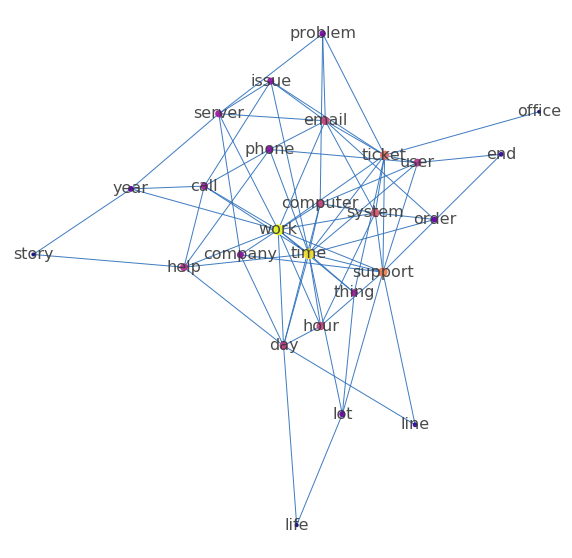

In [136]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

This makes sense: people are talking about work, support, computers, time... it's a tech support forum, so these are expected connections.

What if we want to look at noun-verb pairs instead?

In [137]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

`gNV` has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [138]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2105
Number of edges: 18560
Average degree:  17.6342


In [139]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [140]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2105
Number of edges: 6078
Average degree:   5.7748


Dropping low weight edges and low degree vertices gives us:

In [141]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [142]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 22
Number of edges: 66
Average degree:   6.0000


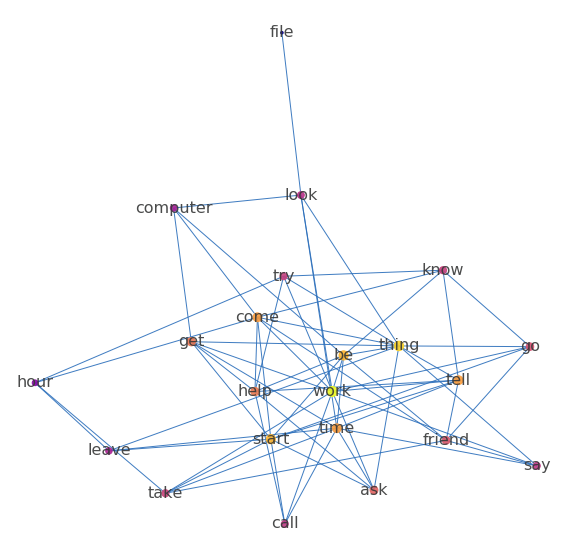

In [143]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Lets create an "ego network" surrounding a single (important) word, as we did before:

In [144]:
g_i = gNV.subgraph(['work'] + list(gNV.neighbors('work')))

In [145]:
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 12
Number of edges: 11
Average degree:   1.8333


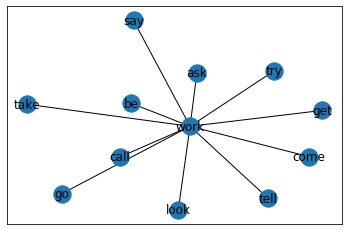

In [146]:
nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'look' (+ points for being meta) for this:

In [147]:
storyNeighbors = gNV.neighbors('look')
set(storyNeighbors)

{'computer', 'file', 'thing', 'time', 'work'}

In [148]:
storyNeighbors = set(gNV.neighbors('look'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [149]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 17
Number of edges: 35
Average degree:   4.1176


This is a mid-sized network, but we can interrogate it intelligently by computing some statistics. Degree centrality:

In [150]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('work', 0.6875),
 ('thing', 0.625),
 ('time', 0.5625),
 ('look', 0.3125),
 ('computer', 0.25),
 ('be', 0.25),
 ('get', 0.25),
 ('tell', 0.1875),
 ('say', 0.1875),
 ('come', 0.1875)]

Or eigenvector centrality:

In [151]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('work', 0.4243874885065112),
 ('thing', 0.39541360211647264),
 ('time', 0.3567611474813666),
 ('look', 0.26677486077190093),
 ('be', 0.2572337058302407),
 ('get', 0.2572337058302407),
 ('tell', 0.22250581433600003),
 ('say', 0.22250581433600003),
 ('ask', 0.22250581433600003),
 ('come', 0.18976474662612278)]

Lets plot it:

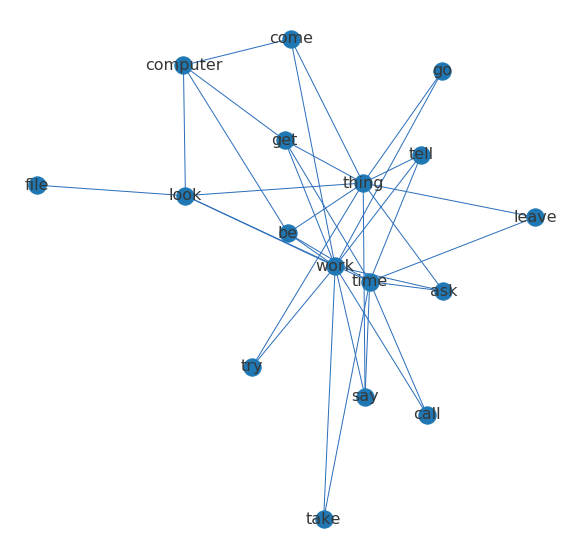

In [152]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

Lets create a noun-adjective network:

In [153]:
gNJ = posCooccurrence(redditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 2582
Number of edges: 19723
Average degree:  15.2773


By filtering by a centrality measure we can get a more 'central' set of nodes instead of just the most connected.

In [154]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 76
Average degree:   6.0800


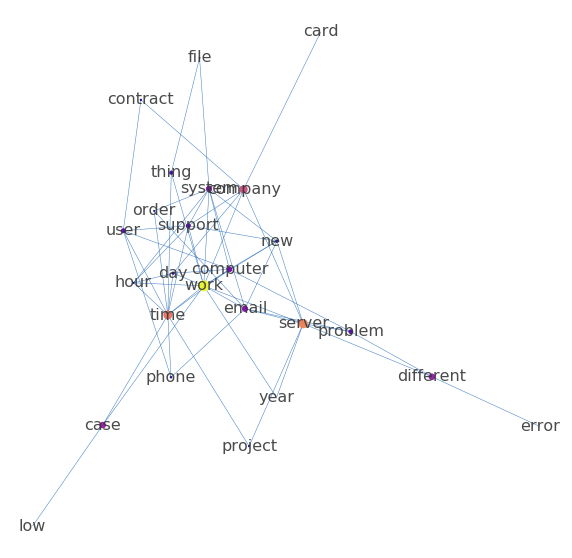

In [155]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

I use all the Minutes for this exercise.

In [156]:
# noun-verb pairs
gNV_Minutes = posCooccurrence(Minutes_df['normalized_sents'].sum(), 'NN', 'VB')
print(nx.info(gNV_Minutes))

Name: 
Type: Graph
Number of nodes: 1741
Number of edges: 74585
Average degree:  85.6806


In [157]:
# Remove noun-noun pairs and verb-verb pairs
gNV_Minutes.remove_edges_from([(n1,n2) for n1,n2,d in gNV_Minutes.edges(data = True) if gNV_Minutes.nodes[n1]['bipartite'] == gNV_Minutes.nodes[n2]['bipartite']])

# Dropping low weight edges and low degree vertices
gNV_Minutes.remove_edges_from([(n1, n2) for n1, n2, d in gNV_Minutes.edges(data = True) if d['weight'] <= 18])
gNV_Minutes.remove_nodes_from([n for n in gNV_Minutes.nodes if len(set(gNV_Minutes.neighbors(n))) <= 10])

print(nx.info(gNV_Minutes))

Name: 
Type: Graph
Number of nodes: 15
Number of edges: 36
Average degree:   4.8000


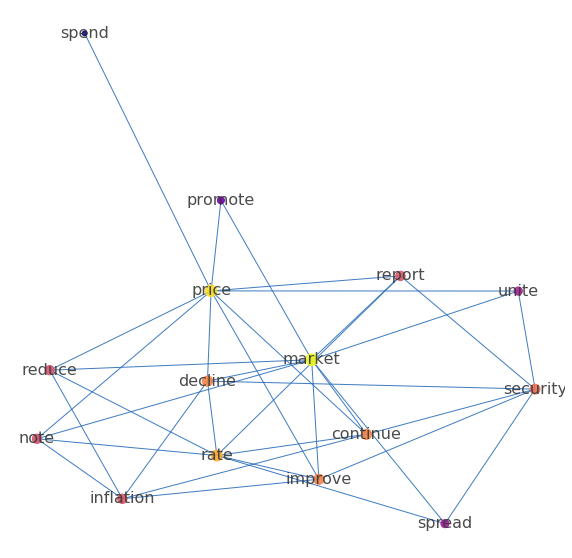

In [158]:
# Visualization
layout_nv_Minutes = nx.spring_layout(gNV_Minutes, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv_Minutes = nx.eigenvector_centrality(gNV_Minutes)
maxC_nv_Minutes = max(centralities_nv_Minutes.items(), key = lambda x : x[1])[1]
maxWeight_nv_Minutes = max((d['weight'] for n1, n2, d in gNV_Minutes.edges(data = True)))
minWeight_nv_Minutes = min((d['weight'] for n1, n2, d in gNV_Minutes.edges(data = True)))
nx.draw(gNV_Minutes, ax = ax, pos = layout_nv_Minutes, labels = {n: n for n in gNV_Minutes.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv_Minutes[n] / maxC for n in gNV_Minutes.nodes],
        node_size = [centralities_nv_Minutes[n] / maxC * 100 for n in gNV_Minutes.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [159]:
# noun-adjective pairs
gNJ_Minutes = posCooccurrence(Minutes_df['normalized_sents'].sum(), 'NN', 'JJ')
print(nx.info(gNJ_Minutes))

Name: 
Type: Graph
Number of nodes: 2200
Number of edges: 118102
Average degree: 107.3655


In [160]:
# Remove noun-noun pairs and adjective-adjective pairs
gNJ_Minutes.remove_edges_from([(n1,n2) for n1,n2,d in gNJ_Minutes.edges(data = True) if gNJ_Minutes.nodes[n1]['bipartite'] == gNJ_Minutes.nodes[n2]['bipartite']])

# Dropping low weight edges and low degree vertices
gNJ_Minutes.remove_edges_from([(n1, n2) for n1, n2, d in gNJ_Minutes.edges(data = True) if d['weight'] <= 24])
gNJ_Minutes.remove_nodes_from([n for n in gNJ_Minutes.nodes if len(set(gNJ_Minutes.neighbors(n))) <= 15])

print(nx.info(gNJ_Minutes))

Name: 
Type: Graph
Number of nodes: 30
Number of edges: 164
Average degree:  10.9333


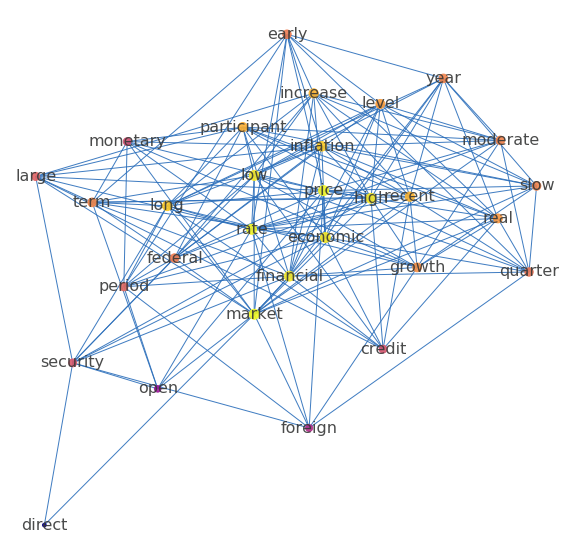

In [161]:
layout_nj_Minutes = nx.spring_layout(gNJ_Minutes, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj_Minutes = nx.eigenvector_centrality(gNJ_Minutes)
maxC_nj_Minutes = max(centralities_nj_Minutes.items(), key = lambda x : x[1])[1]
maxWeight_nj_Minutes = max((d['weight'] for n1, n2, d in gNJ_Minutes.edges(data = True)))
minWeight_nj_Minutes = min((d['weight'] for n1, n2, d in gNJ_Minutes.edges(data = True)))
nx.draw(gNJ_Minutes, ax = ax, pos = layout_nj_Minutes, labels = {n: n for n in gNJ_Minutes.nodes()},
#         width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNJ.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nj_Minutes[n] / maxC_nj_Minutes for n in gNJ_Minutes.nodes],
        node_size = [centralities_nj_Minutes[n] / maxC_nj_Minutes * 100 for n in gNJ_Minutes.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

Name: 
Type: Graph
Number of nodes: 11
Number of edges: 10
Average degree:   1.8182


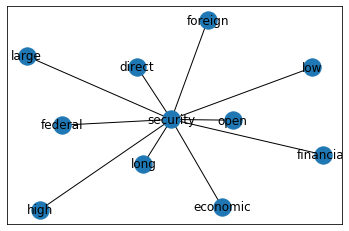

In [162]:
# Ego network surrounding "security" with one link away
g_i_Minutes = gNJ_Minutes.subgraph(['security'] + list(gNJ_Minutes.neighbors('security')))
print(nx.info(g_i_Minutes))
nx.draw_networkx(g_i_Minutes)

In [163]:
# Ego network surrounding "security" with two links away
securityNeighbors = set(gNJ_Minutes.neighbors('security'))
securityNeighbors

{'direct',
 'economic',
 'federal',
 'financial',
 'foreign',
 'high',
 'large',
 'long',
 'low',
 'open'}

In [164]:
securityNeighborsPlus1 = set(securityNeighbors)
for n in securityNeighbors:
    securityNeighborsPlus1 |= set(gNJ_Minutes.neighbors(n))
gNJ_Minutes_security = gNJ_Minutes.subgraph(securityNeighborsPlus1)
print(nx.info(gNJ_Minutes_security))

Name: 
Type: Graph
Number of nodes: 24
Number of edges: 103
Average degree:   8.5833


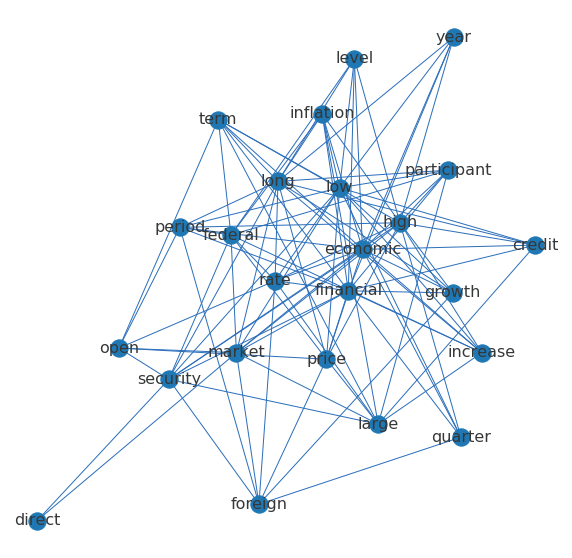

In [165]:
layout_security = nx.spring_layout(gNJ_Minutes_security, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNJ_Minutes_security, ax = ax, pos = layout_security, labels = {n: n for n in gNJ_Minutes_security.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       )

In [166]:
# Ego network surrounding "security" with three links away
securityNeighborsPlus2 = set(securityNeighborsPlus1)
for n in securityNeighborsPlus1:
    securityNeighborsPlus2 |= set(gNJ_Minutes.neighbors(n))
gNJ_Minutes_security_2 = gNJ_Minutes.subgraph(securityNeighborsPlus2)
print(nx.info(gNJ_Minutes_security_2))

Name: 
Type: Graph
Number of nodes: 30
Number of edges: 164
Average degree:  10.9333


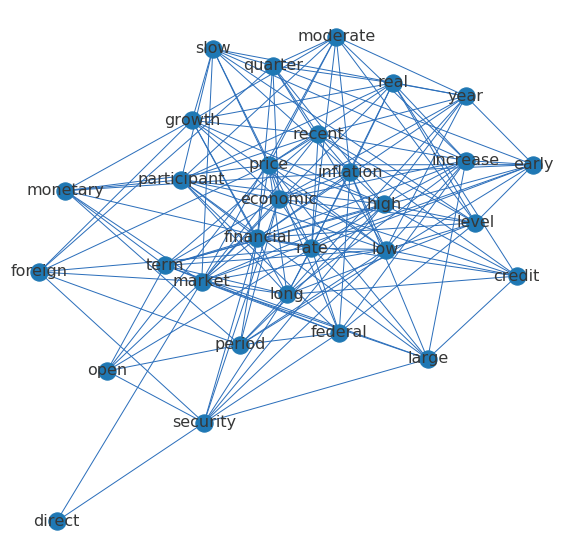

In [167]:
layout_security_2 = nx.spring_layout(gNJ_Minutes_security_2, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNJ_Minutes_security_2, ax = ax, pos = layout_security_2, labels = {n: n for n in gNJ_Minutes_security_2.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       )

### Summary
It could be observed that price level and inflation is always a focus of the central bankers. Although security operation is extremely important after the financial crisis, "security" is not always at the central. This indicates that the monetary polices enacted to tackle the crisis is abnormal and unprecedented. 

## Creating networks of agents from corpora

Now that we have an idea of how we can use networks in python (a useful skill to know!), let us see how we can now use our knowledge of networks on extracting actors from corpora and building relations from them. Let us use the soap opera corpus now. 

In the last notebook we wrote methods to load corpora - this has been added to lucem_illud_2020.
The code returns a dictionary with each id mapping to the text associated with it. 

We would then use the source file to create the dataframe with the data - since this varies for each corpora, there is no built in function, but would follow a similar process.

This function might take some time.

In [168]:
corpora_address = "SOAP"

In [169]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_0-tez.zip
text_1-teh.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_5-rag.zip
text_6-egn.zip
text_7-jss.zip
text_8-sbo.zip
text_9-jtw.zip


We now use the source to see how the data is stored. Note that this is different from the movies corpus, and that we will need to use a different aggregating method to store the data. Each dataset would have a different approach, but they are all very similar, it depends on how the data is stored. Here multiple textids match multiple scripts, so our soap dataframe would be structured a little differently. 

You can see the first 20 lines of the source file here.

In [170]:
import zipfile

In [171]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [172]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [173]:
source[0:20]

[b'textID\tyear\tshow\t\turl\r\n',
 b'-----\t-----\t-----\t\t-----\r\n',
 b'\r\n',
 b'1\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-04-09-01.shtml\r\n',
 b'2\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-05-09-01.shtml\r\n',
 b'3\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-06-20-01.shtml\r\n',
 b'4\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-07-01.shtml\r\n',
 b'5\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-08-01.shtml\r\n',
 b'6\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-09-01.shtml\r\n',
 b'7\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-10-01.shtml\r\n',
 b'8\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-13-01.shtml\r\n',
 b'9\t2001\tAll My Childen\thttp://tvmegasite.net/tra

In [174]:
import pandas as pd

In [175]:
soap_dict = {}

In [176]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [177]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [178]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [179]:
i = 0

In [180]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [181]:
soap_df

Soap Name                                    Tokenized Texts
0      All My Childen  [@!Liza, You, 're, in, early, @!Ryan, Yeah, I,...
1  As the World Turns  [@!Katie, Simon, where, are, you, @!Simon, Kat...
2  Bold and Beautiful  [@!Morgan, What, 's, the, matter, Stephanie, Y...
3   Days of Our Lives  [@!Philip, Seems, like, every, time, I, look, ...
4    General Hospital  [@!Stefan, I, love, her, @!Jax, No, Cassadine,...
5       Guiding Light  [@!Reva, Well, it, 's, very, peaceful, Your, b...
6    One Life to Live  [@!Rae, What, She, even, has, a, new, friend, ...
7            Passions  [@!Kay, Going, to, get, pregnant, and, I, 'm, ...
8        Port Charles  [@!Jack, There, you, are, you, son, @!Chris, H...
9  Young and Restless  [@!Sharon, Yeah, I, could, n't, sleep, @!Victo...

We now have each Soap, and each of the Tokenized texts. Let us see what kind of information we can get. These are American soap operas, and are likely to be cheesy and dramatic (an understatment). A fun start would be to make networks of each of the actors and actresses in these soaps. 

What would be a good way to create a network? Maybe everytime someone talks to someone we add one weight? But we wouldn't want to add weights whenever it's a different scene - or maybe we do? Let us look at the text and figure it out.

Note that we didn't add the year here because it spans over multiple years. If we are doing different kinds of analysis we would want to a years column as well.

In my dataframe, Days of Our Lives is the 9th corpora, and I conducted my basic analysis on that.

In [182]:
dool = soap_df['Tokenized Texts'][3]

In [183]:
' '.join(dool[0:1500])

"@!Philip Seems like every time I look at you tonight you 're crying @!Chloe Tears of happiness I always thought that when I read Tears of Happiness what a crock But tonight you prove to me that they really do exist @!Philip I just carved our initials on that tree @!Chloe But it was so much more than that You took this angry outsider and you made her feel like a girl in a movie or a book a happy movie or a book @!Philip That 's what you deserve to be What gets me is that you do n't even realize how special you are @!Chloe All my life the word special was code for too weird for words And now here you are this great looking guy with a normal life and you make me believe like you really actually want me around @!Philip Oh that 's only half true @!Chloe Oh I 'm sorry @!Philip Oh no Chloe I want you around forever That 's so true but 's not true at all Except for you there 's nothing normal at all about my life @!Brenda We got to get the labs back on 23 @!Woman I 'll grab them @!Brenda Okay

Hmmm... we can't do our normal text processing. But this provides us with an interesting oppurtunity: every '@!' is followed by some useeful information. Let us do a quick check of how many characters exist here, and how many times they speak.

In [184]:
characters = {}

In [185]:
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1


In [186]:
len(characters)

878

Wow, that's a lot of characters: but we notice a '@!' between certain actions too, such as screaming and sobbing. Let us maybe only look for characters with a high number of appearances?

In [187]:
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

Philip 2846
Bo 4179
Shawn 2507
Hope 3793
Belle 2518
John 2542
Brady 2265
Marlena 2458
Nicole 2892
Kate 2503
Sami 5462
Lucas 2546


Let's check these folks out on the interwebz...a image of search of the name + "days of our lives":

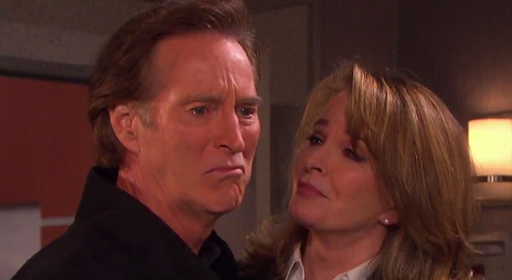

In [188]:
Image(filename='../data/dool/dool_john.png') 

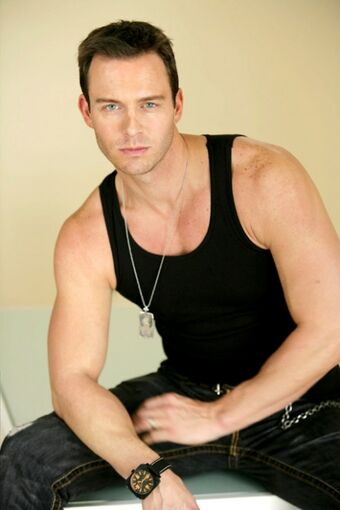

In [189]:
Image(filename='../data/dool/dool_brady.jpg') 

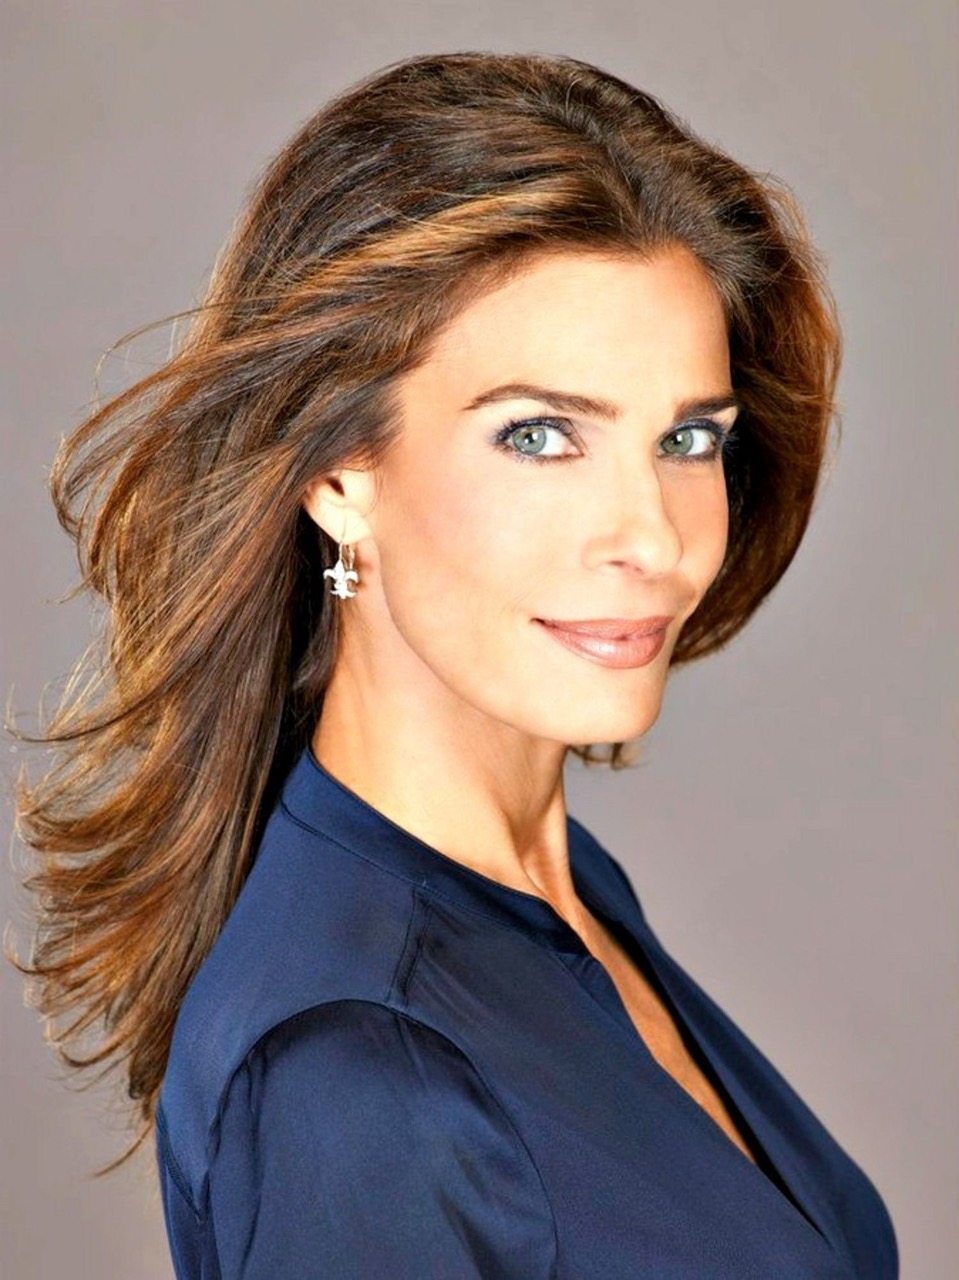

In [190]:
Image(filename='../data/dool/dool_hope.jpeg')

In [191]:
# Image(filename='../data/dool/dool_philip.jpeg')

In [192]:
# Image(filename='../data/dool/dool_marlena.jpg')

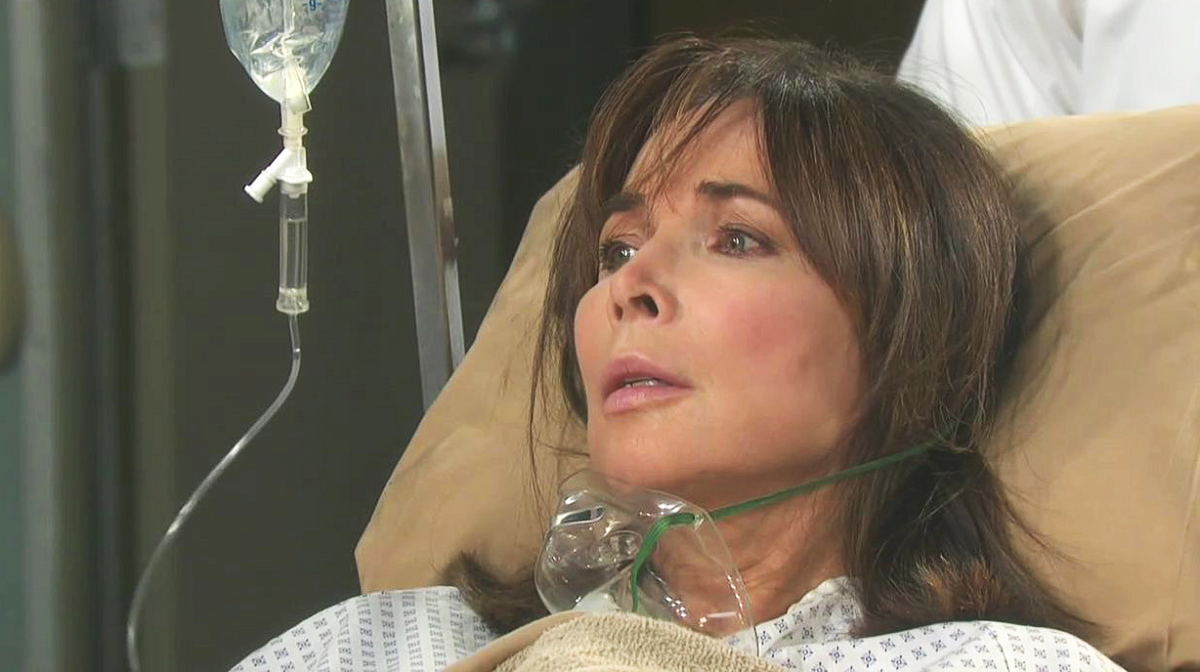

In [193]:
Image(filename='../data/dool/dool_kate.png')

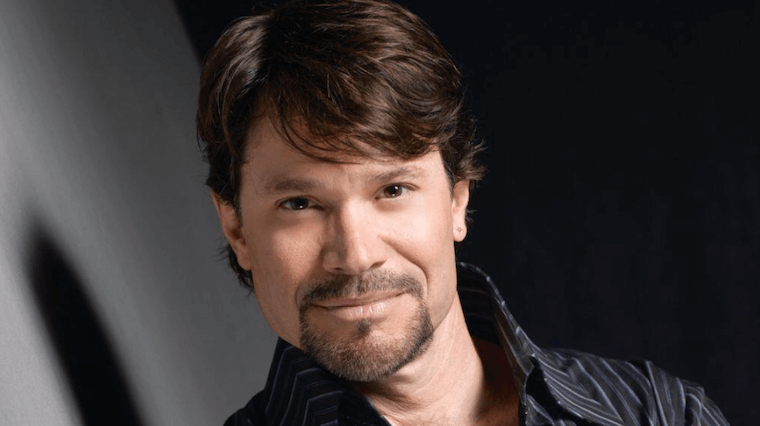

In [194]:
Image(filename='../data/dool/dool_bo.png')

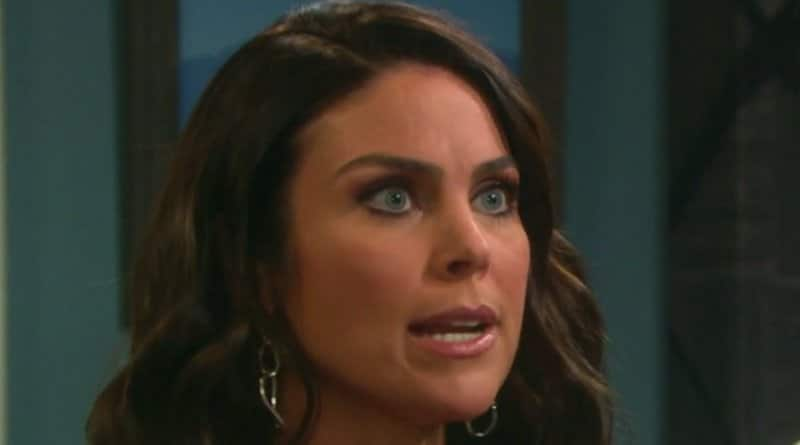

In [195]:
Image(filename='../data/dool/dool_chloe.jpg')

In [196]:
# Image(filename='../data/dool/dool_sami.jpg')

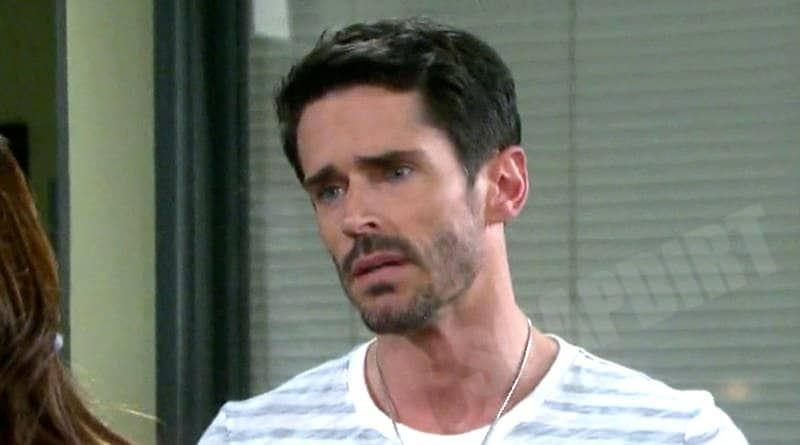

In [197]:
Image(filename='../data/dool/dool_shawn.jpg')

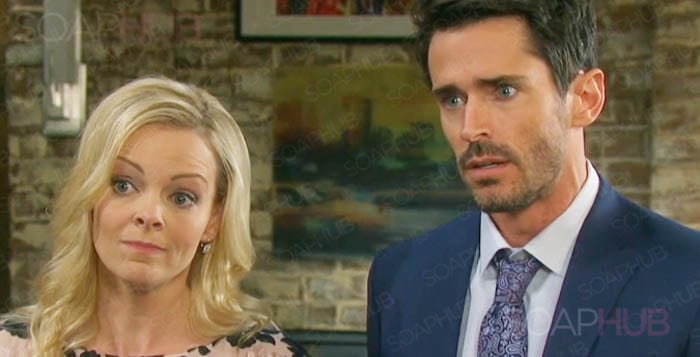

In [198]:
Image(filename='../data/dool/dool_belle.jpg')

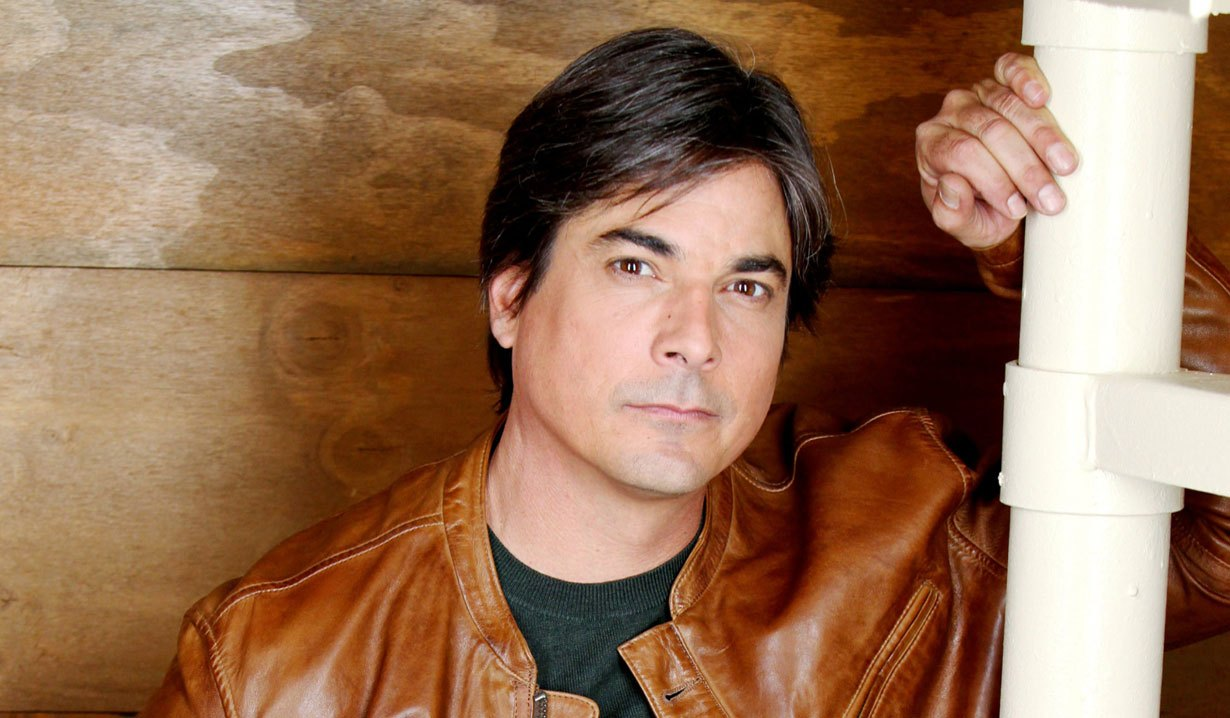

In [199]:
Image(filename='../data/dool/dool_lucas.jpg')

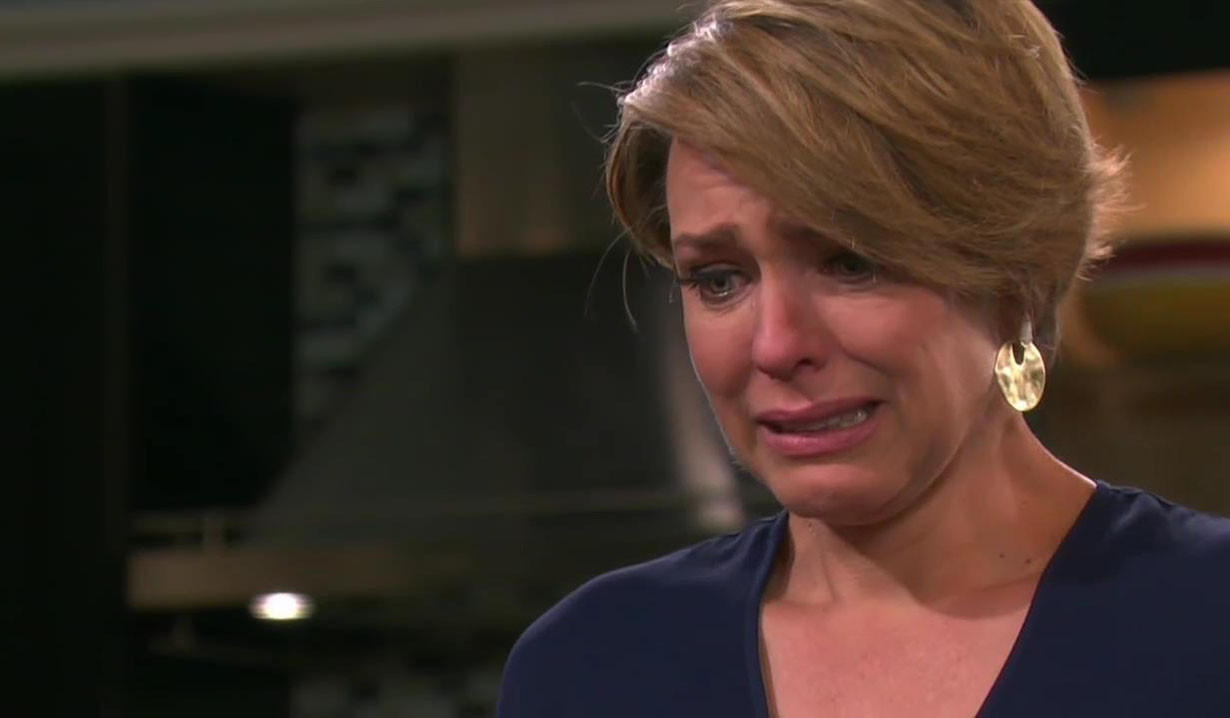

In [200]:
Image(filename='../data/dool/dool_nicole.jpg')

These are definitely big, long-time players in the dramatic Days narrative. It would make sense to create a graph where each character who appears over 2000 times is a node, and each time they talk to each other, we add one to their weight. We should also store all the things these chracters say: that's useful information.

So we now iterate through the tokens in a manner where we can capture this information.

In [201]:
actor_network = nx.Graph()

In [202]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [203]:
len(actor_network.nodes.data())

12

In [204]:
actor_network.nodes.data()

NodeDataView({'Philip': {'lines_spoken': 2846, 'words': []}, 'Bo': {'lines_spoken': 4179, 'words': []}, 'Shawn': {'lines_spoken': 2507, 'words': []}, 'Hope': {'lines_spoken': 3793, 'words': []}, 'Belle': {'lines_spoken': 2518, 'words': []}, 'John': {'lines_spoken': 2542, 'words': []}, 'Brady': {'lines_spoken': 2265, 'words': []}, 'Marlena': {'lines_spoken': 2458, 'words': []}, 'Nicole': {'lines_spoken': 2892, 'words': []}, 'Kate': {'lines_spoken': 2503, 'words': []}, 'Sami': {'lines_spoken': 5462, 'words': []}, 'Lucas': {'lines_spoken': 2546, 'words': []}})

In [205]:
actor_network.nodes['Sami']['lines_spoken']

5462

In [206]:
i = 0

The following lines of code creates the graph. Please carefully go through the code: you should be able to understand (more or less) what is going on here. 

In [207]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

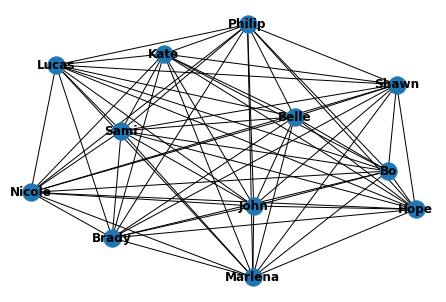

In [208]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [209]:
import seaborn as sns

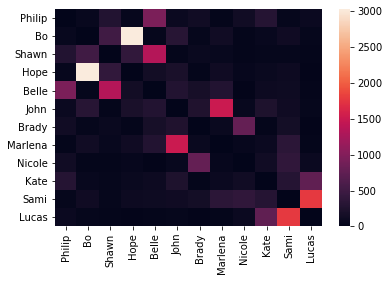

In [210]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [211]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(actor_network))

In [212]:
c

[frozenset({'Belle',
            'Bo',
            'Brady',
            'Hope',
            'John',
            'Kate',
            'Lucas',
            'Marlena',
            'Nicole',
            'Philip',
            'Sami',
            'Shawn'})]

### Finding structure in networks

We now have a lot of useful information: we have a graph of all the characters, with their relationships with other characters, as well as all the words they've said. We tried finding communities, but it seems like everyone is connected to everyone: each of them form their own 'community'. Seems like people talk to each other a bunch in soaps.

This is however, not the best network to find any meaningful patterns, as we can see with everyone connected to everyone. But as we can see with our heatmap, not everyone talks to everyone an equal amount. How about we only keep our "important" ties, where people are talking to each other a lot?

In [213]:
smaller_actor_network = nx.Graph()

In [214]:
for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 250:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])


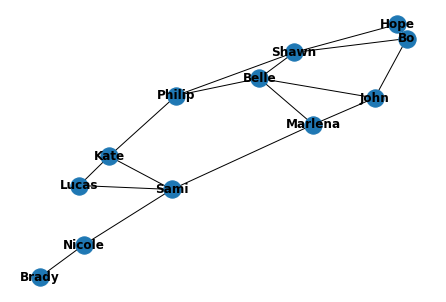

In [215]:
nx.draw(smaller_actor_network, with_labels=True, font_weight='bold')

This is a lot more interesting: while the sets of characters overlap, there is still two distinct communities if you look at characters who regularly talk to each other!

Let us see what our centrality measures look like, as well as communities.

In [216]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(smaller_actor_network))

In [217]:
c

[frozenset({'Belle',
            'Bo',
            'Brady',
            'Hope',
            'John',
            'Kate',
            'Lucas',
            'Marlena',
            'Nicole',
            'Philip',
            'Sami',
            'Shawn'})]

In [218]:
dcentralities = nx.degree_centrality(smaller_actor_network)

In [219]:
dcentralities['John'], dcentralities['Philip']

(0.2727272727272727, 0.2727272727272727)

Our two different communities show up as detected by the networkx algorithm, and when we look at centralities, we can see that John is a lot more central than Philip.

Let us go back to our original graph, and see if the weight or number of similar appearences matches the text... how do we do this? Well, we already have the graph, and we also have information of who spoke to who. So we have our framework!

This means we can explore ideas contained in two of the papers you will be reading: . “No country for old members: User lifecycle and linguistic change in online communities.”, and  “Fitting In or Standing Out? The Tradeoffs of Structural and Cultural Embeddedness”, both of which you can access on Canvas. 

Let us use a simplified version of the papers, and check if a higher number of conversations might lead to a higher similarity between the word distributions for two characters. We can use the same divergences we used in the last notebook. Do you think it will match with the number of times each character was associated with each other?

In [220]:
import nltk

In [221]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [222]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud_2020.normalizeTokens(character_words))

In [223]:
L = []

In [224]:
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

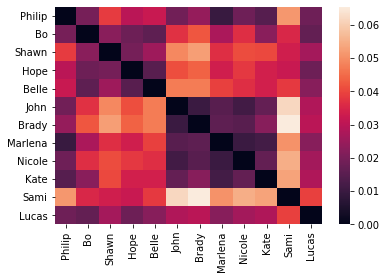

In [225]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [226]:
# np.corrcoef(M_, M)[0]

With our two heatplots, we can attempt to do some rudimentary analysis. We can see from our previous plot that Shawn and Belle talk to each other a lot, so do Hope and Bo, and Nicole and Brady, and Lucas and Sami. Do they also talk *like* each other?

Kind of, actually: all four of these pairs have a lower distance between them. Now I don't know anything about this particular soap... are these four pairs related? Are they in a relationship, either married or dating, or are they just really good friends?

This lays out the frameworks which you can now use to explore your own networks. 

# Interactional influence

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [227]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [228]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [229]:
df_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pandas.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Juror 8': 0,
 'Juror 3': 1,
 'Juror 10': 2,
 'Foreman': 3,
 'Juror 7': 4,
 'Juror 4': 5,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 6': 8,
 'Juror 2': 9,
 'Juror 9': 10,
 'Juror 5': 11}

In [230]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

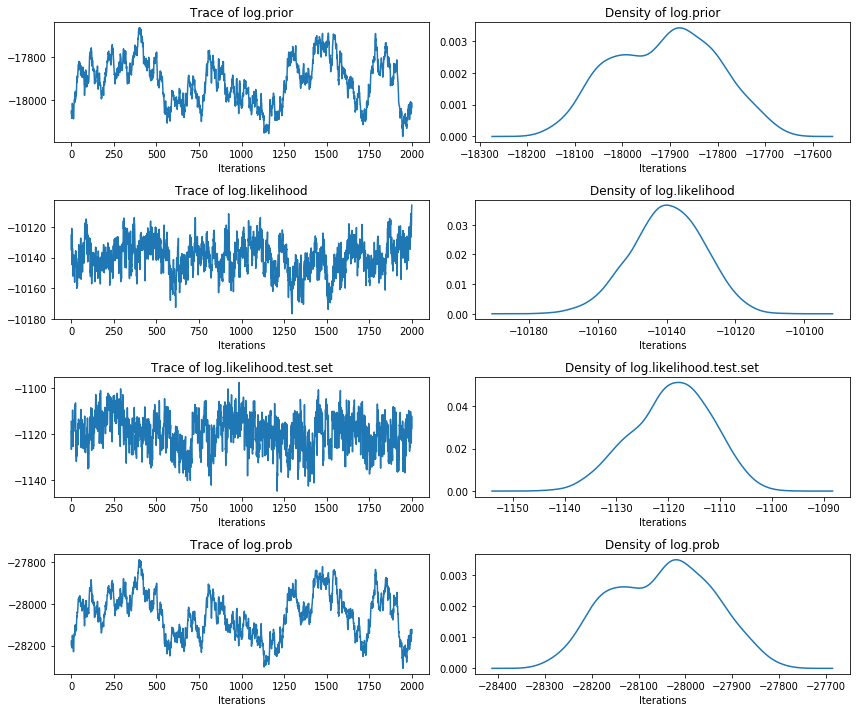

In [231]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [232]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [233]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pandas.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [234]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [235]:
df_mean

Juror 8   Juror 3  Juror 10   Foreman   Juror 7   Juror 4  \
Juror 8   0.000000  3.757957  8.089079  0.930180  5.167497  0.794645   
Juror 3   8.529312  0.000000  6.673916  4.150076  2.534751  4.902852   
Juror 10  8.413188  7.427932  0.000000  4.540236  3.216307  1.030049   
Foreman   1.137060  0.612615  1.945196  0.000000  1.521390  0.834870   
Juror 7   2.603853  5.901169  0.648844  1.969868  0.000000  1.110101   
Juror 4   5.791320  0.200669  0.266484  0.582956  0.094200  0.000000   
Juror 11  0.378515  0.544628  0.779340  0.454645  0.290575  0.447512   
Juror 12  5.961338  0.695831  0.519459  1.253033  0.247939  0.162463   
Juror 6   4.526244  0.923784  0.503503  1.049825  1.288920  0.451562   
Juror 2   0.583732  2.303417  0.529583  1.722894  2.005939  0.299311   
Juror 9   1.216641  1.281288  0.967587  1.675483  1.657341  1.681338   
Juror 5   0.552951  1.001575  0.696393  1.180245  1.180355  0.497265   

          Juror 11  Juror 12   Juror 6   Juror 2   Juror 9   Juror 5  
Juror 8   0.845335  1.336329  6.106684  0.916765  6.385205  7.300776  
Juror 3   1.092571  0.509942  3.825015  3.861767  0.266426  1.561626  
Juror 10  1.004598  0.529232  2.426582  0.407460  1.233599  0.885871  
Foreman   1.338554  3.230634  1.013511  3.534036  1.311436  4.115411  
Juror 7   0.279870  0.608548  1.047693  2.910670  1.619475  1.570038  
Juror 4   3.347982  0.316963  0.300770  2.112033  0.370973  0.673364  
Juror 11  0.000000  0.614536  0.821143  0.951222  0.476986  0.844157  
Juror 12  0.388620  0.000000  2.500976  2.375977  0.481394  0.834032  
Juror 6   0.375776  0.904313  0.000000  2.861587  0.905421  0.310822  
Juror 2   0.652302  1.623813  0.841376  0.000000  1.691612  1.756225  
Juror 9   0.623032  1.925996  1.907992  0.539666  0.000000  1.138934  
Juror 5   0.786181  0.588822  0.724613  0.912616  1.224854  0.000000

MEAN of influence matrix (row=from, col=to)


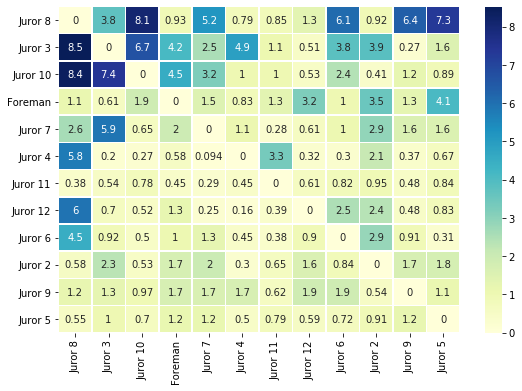

In [236]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


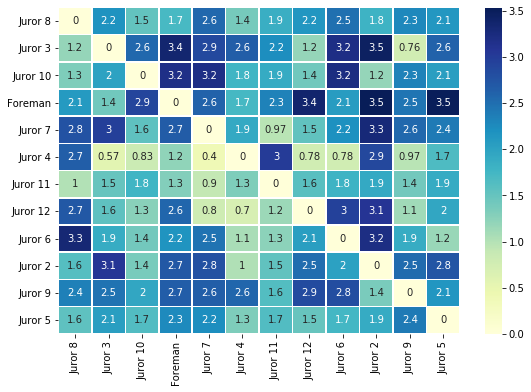

In [237]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [238]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


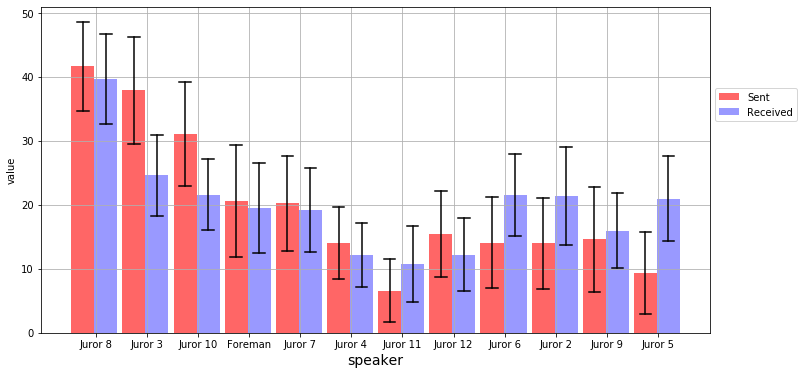

In [239]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [240]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [241]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


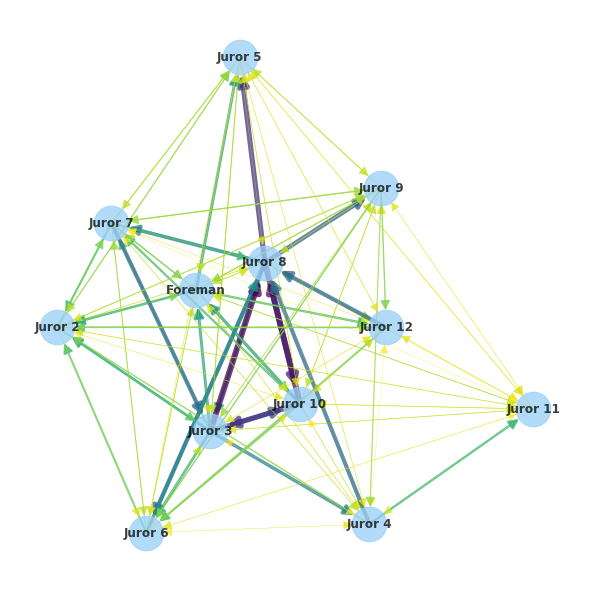

In [242]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


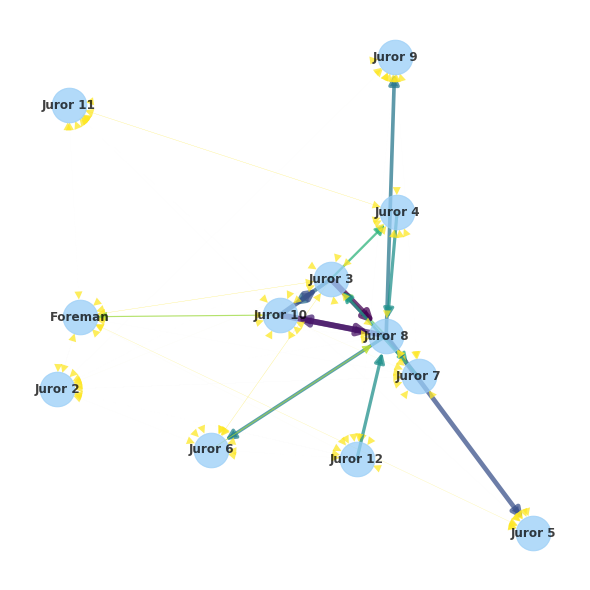

In [243]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


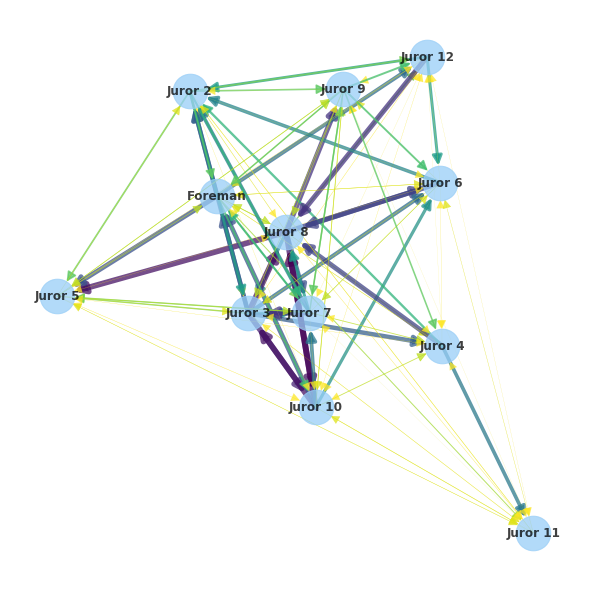

In [244]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [245]:
import lucem_illud_2020
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [246]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

name                                             tokens     start  \
0    Ford  [ejaa, dbll, fcik, ieil, eabk, gehi, lcik, fbs...  0.226690   
1  Reagan  [klei, hghb, gfec, adbc, bssh, aegl, kfge, esk...  2.113129   

        end  
0  1.036051  
1  3.667018

Transform data into TalkbankXML format:

In [247]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud_2020.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to .\data\USpresident\USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [248]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud_2020.bec_run(output_fname, Vocab_size, language, sampling_time)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<span style="color:red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<span style="color:red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

For this exercise, I would use another soap opera: The Bold and The Beautiful because the FOMC Minutes does not include conversations or characters.
### Part 1: Examine the relationship between characters by their conversations.

In [249]:
bab = soap_df['Tokenized Texts'][8]

In [250]:
# Extract all the characters
characters_bab = {}

for token in bab:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters_bab:
            characters_bab[token[2:]] = 0
        if token[2:] in characters_bab:
            characters_bab[token[2:]] += 1
            
len(characters_bab)

226

In [251]:
# Delete characters with low number of appearances
for character in characters_bab:
    if characters_bab[character] > 300:
        print(character, characters_bab[character])

Jack 913
Kevin 952
Eve 487
Ian 1046
Lucy 1317
Livvie 940
Karen 418
Frank 306
Alison 1372
Jamal 854
Caleb 397
Rafe 822


In [252]:
# Create a network graph
actor_network_bab = nx.Graph()

for character in characters_bab:
    if characters_bab[character] > 300:
        actor_network_bab.add_node(character, lines_spoken=characters_bab[character], words=[])

In [253]:
i = 0

for token in bab:
    i += 1
    if i > len(bab):
        break
    if token[0] == "@":
        if token[2:] in actor_network_bab.nodes():
            j = i
            for token_ in bab[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network_bab.nodes():
                        if (token[2:], token_[2:]) not in actor_network_bab.edges():
                            actor_network_bab.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network_bab.edges():
                            actor_network_bab.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network_bab.nodes[token[2:]]['words'].append(bab[i:j])

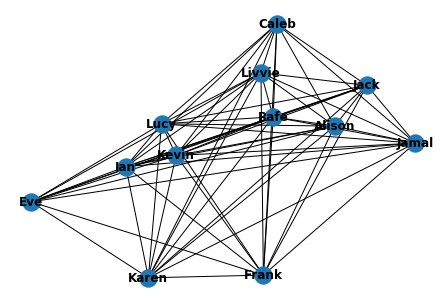

In [254]:
nx.draw(actor_network_bab, with_labels=True, font_weight='bold')

In [255]:
# Since almost everyone is connected to everyone, keep only the important ties
smaller_actor_network_bab = nx.Graph()

for actor_1 in actor_network_bab.nodes():
    smaller_actor_network_bab.add_node(actor_1, lines_spoken=actor_network_bab.nodes[actor_1]['lines_spoken'], 
                                       words=actor_network_bab.nodes[actor_1]['words'])
    for actor_2 in actor_network_bab.nodes():
        if actor_2 != actor_1: # Add a try/except block to deal with zero weight
            try:
                weight = actor_network_bab.edges[(actor_1, actor_2)]['weight']
            except KeyError:
                pass
            else:
                if weight > 75:
                    smaller_actor_network_bab.add_edge(actor_1, actor_2, 
                                                       weight=actor_network_bab.edges[(actor_1, actor_2)]['weight'])

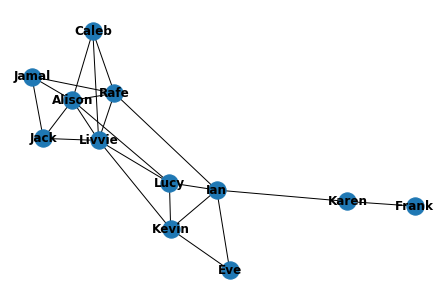

In [256]:
nx.draw(smaller_actor_network_bab, with_labels=True, font_weight='bold')

In [257]:
# What if I only include edges with weights larger than 120?
much_smaller_actor_network_bab = nx.Graph()

for actor_1 in actor_network_bab.nodes():
    much_smaller_actor_network_bab.add_node(actor_1, lines_spoken=actor_network_bab.nodes[actor_1]['lines_spoken'], 
                                            words=actor_network_bab.nodes[actor_1]['words'])
    for actor_2 in actor_network_bab.nodes():
        if actor_2 != actor_1: # Add a try/except block to deal with zero weight
            try:
                weight = actor_network_bab.edges[(actor_1, actor_2)]['weight']
            except KeyError:
                pass
            else:
                if weight > 120:
                    much_smaller_actor_network_bab.add_edge(actor_1, actor_2, 
                                                            weight=actor_network_bab.edges[(actor_1, actor_2)]['weight'])

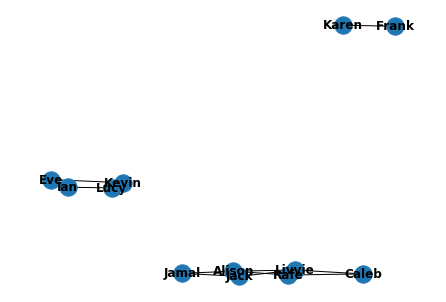

In [258]:
nx.draw(much_smaller_actor_network_bab, with_labels=True, font_weight='bold')

In [259]:
c_bab = list(greedy_modularity_communities(much_smaller_actor_network_bab))
c_bab

[frozenset({'Alison', 'Caleb', 'Jack', 'Jamal', 'Livvie', 'Rafe'}),
 frozenset({'Eve', 'Ian', 'Kevin', 'Lucy'}),
 frozenset({'Frank', 'Karen'})]

In [260]:
# Examine the similarity between characters
corpora_bab = []
for character in actor_network_bab.nodes():
    character_words_bab = []
    for sentence in actor_network_bab.nodes[character]['words']:
        for word in sentence:
            character_words_bab.append(word)
    corpora_bab.append(lucem_illud_2020.normalizeTokens(character_words_bab))

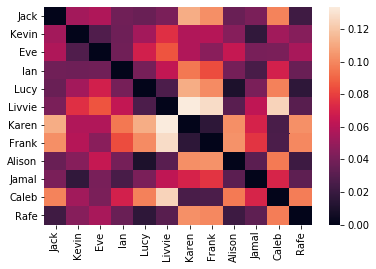

In [261]:
L_bab = []

for p in corpora_bab:
    l_bab = []
    for q in corpora_bab:
        l_bab.append(Divergence(p, q, difference='KS'))
    L_bab.append(l_bab)
M_bab = np.array(L_bab)

fig = plt.figure()
div = pandas.DataFrame(M_bab, columns = list(actor_network_bab.nodes()), index = list(actor_network_bab.nodes()))
ax = sns.heatmap(div)
plt.show()

In [262]:
# Find the most central character with smaller network since all the actors are connected
dcentralities_bab = nx.degree_centrality(smaller_actor_network_bab)
sorted(dcentralities_bab.items(), key=lambda x: x[1])

[('Frank', 0.09090909090909091),
 ('Eve', 0.18181818181818182),
 ('Karen', 0.18181818181818182),
 ('Jack', 0.2727272727272727),
 ('Jamal', 0.2727272727272727),
 ('Caleb', 0.2727272727272727),
 ('Kevin', 0.36363636363636365),
 ('Lucy', 0.36363636363636365),
 ('Ian', 0.4545454545454546),
 ('Rafe', 0.4545454545454546),
 ('Livvie', 0.5454545454545454),
 ('Alison', 0.5454545454545454)]

### Summary
If we only keep the edges with weights larger than 75, we can see that all characters are still connected to each other, but there is a tendency that Karen and Frank are in a small group, Kevin, Lucy, Ian, and Eve are in a small group, and the others are in another group. If we keep the edges with weights larger than 120, this tendency could be seen clearly. The heatmap shows that Karen and Frank are really similar to each other and Kevin, Lucy, Ian, and Eve are also similar to each other, given the color of the cells are relatively darker. According to degree centrality, Livvie and Alison are at the center of the network.

### Part 2: Examine the relationship between characters by the word "love"

In [263]:
# Create a new network graph
actor_network_love = nx.Graph()

for character in characters_bab:
    if characters_bab[character] > 300:
        actor_network_love.add_node(character, lines_spoken=characters_bab[character], words=[])

In [264]:
i = 0
love_indicator = False

for token in bab:
    i += 1
    if i > len(bab):
        break
    if token[0] == "@":
        if token[2:] in actor_network_love.nodes():
            j = i
            for token_ in bab[i:]:
                if token_ == "love":
                    love_indicator = True
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network_love.nodes() and love_indicator == True:
                        if (token[2:], token_[2:]) not in actor_network_love.edges():
                            actor_network_love.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network_love.edges():
                            actor_network_love.edges[(token[2:], token_[2:])]['weight'] += 1
                        love_indicator = False
                    break
                j += 1
            # adding characters sentences
            actor_network_love.nodes[token[2:]]['words'].append(bab[i:j])

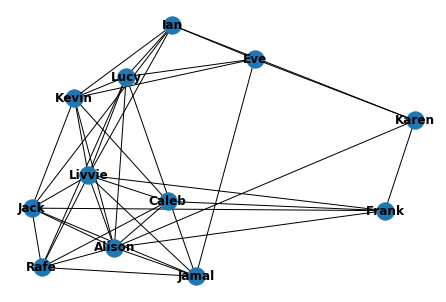

In [265]:
nx.draw(actor_network_love, with_labels=True, font_weight='bold')

In [266]:
# Since almost everyone is connected to everyone, keep only the important ties
smaller_actor_network_love = nx.Graph()

for actor_1 in actor_network_love.nodes():
    smaller_actor_network_love.add_node(actor_1, lines_spoken=actor_network_love.nodes[actor_1]['lines_spoken'], 
                                        words=actor_network_love.nodes[actor_1]['words'])
    for actor_2 in actor_network_love.nodes():
        if actor_2 != actor_1: # Add a try/except block to deal with zero weight
            try:
                weight = actor_network_love.edges[(actor_1, actor_2)]['weight']
            except KeyError:
                pass
            else:
                if weight > 8:
                    smaller_actor_network_love.add_edge(actor_1, actor_2, 
                                                        weight=actor_network_love.edges[(actor_1, actor_2)]['weight'])

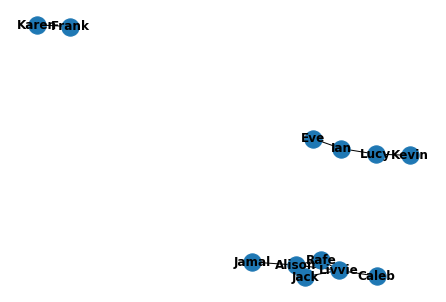

In [267]:
nx.draw(smaller_actor_network_love, with_labels=True, font_weight='bold')

In [268]:
c_love = list(greedy_modularity_communities(smaller_actor_network_love))
c_love

[frozenset({'Alison', 'Caleb', 'Jack', 'Jamal', 'Livvie', 'Rafe'}),
 frozenset({'Eve', 'Ian', 'Kevin', 'Lucy'}),
 frozenset({'Frank', 'Karen'})]

In [269]:
# Find the most central character with smaller network
dcentralities_love = nx.degree_centrality(smaller_actor_network_love)
sorted(dcentralities_love.items(), key=lambda x: x[1])

[('Kevin', 0.09090909090909091),
 ('Eve', 0.09090909090909091),
 ('Caleb', 0.09090909090909091),
 ('Karen', 0.09090909090909091),
 ('Frank', 0.09090909090909091),
 ('Jamal', 0.09090909090909091),
 ('Jack', 0.18181818181818182),
 ('Lucy', 0.18181818181818182),
 ('Ian', 0.18181818181818182),
 ('Rafe', 0.18181818181818182),
 ('Livvie', 0.36363636363636365),
 ('Alison', 0.36363636363636365)]

### Summary
The results from the network constructed by the word "love" are quite similar. Karen and Frank love each other. Eve loves Ian, Ian loves Eve and Lucy, Lucy loves Ian and Kevin, while Kevin loves Lucy. The remainings are in a "love" group. The rank of degree centrality does not change, with Livvie and Alison are at the center. I do not draw the similarity heatmap since it is the same as the one in part 1. However, I think a network graph with direction indicating the the direction of "love" would reveal more information. It is possible that the two characters are connected with each other only because one guy loves the other but the other does not love that guy.

## Conversational Analysis using ConvoKit

The accompanying notebook [convokit](https://github.com/Computational-Content-Analysis-2020/Content-Analysis-2020/blob/master/week-4/convokit.ipynb) demonstrates the capacities of CornellNLP's package convokit, which provides multiple ways to analyse networks of conversations.

There are 6 different approaches illustrated:

1. Measures of linguistic coordination
2. Politeness strategy
3. Prompt type
4. Hypergraph conversation representation
5  Linguistic diversity in conversations
6. Forecasting of conversation outcomes

The examples illustrate these methods using the built in datasets which ConvoKit offers. This [Jupyter notebook](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/converting_movie_corpus.ipynb) demonstrates how to convert your own corpora so that you can easily use the metrics provided in convokit. 

## <span style="color:red">*Exercise 5*</span>

<span style="color:red"> Implement one (or more) of the metrics from ConvoKit on your dataset of choice; what does it reveal about the social game of your dataset?

For this exercise I will use the Friends Corpus provided by ConvoKit. I am going to examine the measures of linguistic coordination as illustrated in the notebook [convokit](https://github.com/Computational-Content-Analysis-2020/Content-Analysis-2020/blob/master/week-4/convokit.ipynb).

In [270]:
# Import the library
import convokit
from convokit import download
from convokit import Corpus

In [271]:
# Download the corpus
corpus = convokit.Corpus(filename=convokit.download("friends-corpus"))

Dataset already exists at C:\Users\Thinkpad\.convokit\downloads\friends-corpus


In [272]:
# Extract the six main characters and other characters
main_characters = ['Rachel Green', 'Monica Geller', 'Phoebe Buffay', 'Joey Tribbiani', 'Chandler Bing', 'Ross Geller']
six = list(corpus.iter_users(lambda user: user.id in main_characters))
everyone = list(corpus.iter_users())

In [273]:
# Compute coordination scores on this corpus
coord = convokit.Coordination()
coord.fit(corpus)

# Get coordination scores
coord.transform(corpus)

In [274]:
# compute coordination from each main character to everyone
print("Main characters, ranked by how much they coordinate to others:")
six_to_everyone = coord.score(corpus, six, everyone)
for mc, score in sorted(six_to_everyone.averages_by_user().items(),
    key=lambda x: x[1], reverse=True):
    print(mc.id, round(score, 5))
print()

Main characters, ranked by how much they coordinate to others:
Chandler Bing 0.03887
Joey Tribbiani 0.03739
Phoebe Buffay 0.03183
Rachel Green 0.03076
Monica Geller 0.02906
Ross Geller 0.02874



In [275]:
# compute coordination from everyone to each main character
print("Main characters, ranked by how much others coordinate to them:")
everyone_to_six = coord.score(corpus, everyone, six, focus="targets")
for mc, score in sorted(everyone_to_six.averages_by_user().items(), 
    key=lambda x: x[1], reverse=True):
    print(mc.id, round(score, 5))
print()

Main characters, ranked by how much others coordinate to them:
Monica Geller 0.03659
Chandler Bing 0.03283
Rachel Green 0.0295
Ross Geller 0.02917
Joey Tribbiani 0.0278
Phoebe Buffay 0.02192



### Summary
For Monica, there is more coordination from everyone to her, but less coordination from her to everyone. This may reflect the fact that she is strongly manipulative. For Joey, there is more coordination from him to everyone, but less coordination from everyone to him. This may reflect his naivity and foolness. for Chandler, there is relatively more coordination both from and to him. This may reflect both his strong sense of humor (which attracts others) and sensitivity (which forces him to reach others). For Ross, there is relatively less coordination both from and to him. This may reflect his dull and old-fashioned thoughts and awkward behaviors. 